<a href="https://colab.research.google.com/github/darthfelipe21/Data_Scientist/blob/main/Proyecto_banca_propension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pension Plan:** Producto más vendido.

**Short Term Deposit:** Las ventas disminuyeron drásticamente desde noviembre de 2018 y en 2019 no se registró ninguna venta.

**Long Term Deposit:** Las ventas disminuyeron drásticamente desde marzo de 2019.

In [ ]:
#Librerias basicas para manipular datos
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Librerias machine learning
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, average_precision_score, roc_curve, auc
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

# Ignorar advertencias que suele arrojar la plataforma de colab
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Carga de los CSV, asignandoles una variable
df1= pd.read_csv('customer_commercial_activity.csv')
df2= pd.read_csv('customer_products.csv')
df3= pd.read_csv('customer_sociodemographics.csv')
df4= pd.read_csv('product_description.csv')
df5= pd.read_csv('sales.csv')

In [ ]:
df4.rename(columns={'pk_product_ID': 'product_ID'}, inplace=True)

In [ ]:
df_sales= df4.merge(df5, on= 'product_ID', how= 'left')
df_sales

,Unnamed: 0_x,product_ID,product_desc,family_product,Unnamed: 0_y,pk_sale,cid,month_sale,net_margin
0,0,4657,em_acount,account,123338,130004,15891,2018-07-01,66.4
1,0,4657,em_acount,account,123339,130005,16203,2019-01-01,96.7
2,0,4657,em_acount,account,123340,130006,16502,2018-10-01,64.3
3,0,4657,em_acount,account,123341,130007,21719,2018-12-01,60.5
4,0,4657,em_acount,account,123342,130008,22635,2019-02-01,65.7
...,...,...,...,...,...,...,...,...,...
240768,12,4033,mortgage,loan,4471,11137,1296926,2019-04-01,3345.1
240769,12,4033,mortgage,loan,4472,11138,1383262,2019-04-01,1741.6
240770,12,4033,mortgage,loan,4473,11139,1392320,2018-05-01,2291.0
240771,12,4033,mortgage,loan,4474,11140,1399438,2018-06-01,1629.0


In [ ]:
# Calculo de media en margen neto para cada producto elegido para analisis
df_pp_mean= df_sales[df_sales['product_desc']== 'pension_plan']['net_margin'].mean().astype(int)
df_st_mean= df_sales[df_sales['product_desc']== 'short_term_deposit']['net_margin'].mean().astype(int)
df_lt_mean= df_sales[df_sales['product_desc']== 'long_term_deposit']['net_margin'].mean().astype(int)

In [ ]:
print('Pension plan=',df_pp_mean, '  Short Term Deposit=',df_st_mean, '  Long Term Deposit=',df_lt_mean)

Pension plan= 5976   Short Term Deposit= 1486   Long Term Deposit= 1496


In [ ]:
# Eliminar columnas que no se usaran en el analisis en sales
df_sales= df_sales.drop(['Unnamed: 0_x', 'Unnamed: 0_y', 'product_ID', 'net_margin', 'family_product'], axis=1)
df_sales

,product_desc,pk_sale,cid,month_sale
0,em_acount,130004,15891,2018-07-01
1,em_acount,130005,16203,2019-01-01
2,em_acount,130006,16502,2018-10-01
3,em_acount,130007,21719,2018-12-01
4,em_acount,130008,22635,2019-02-01
...,...,...,...,...
240768,mortgage,11137,1296926,2019-04-01
240769,mortgage,11138,1383262,2019-04-01
240770,mortgage,11139,1392320,2018-05-01
240771,mortgage,11140,1399438,2018-06-01


In [ ]:
# Formato de month_sale de df_sales
df_sales['month_sale'] = pd.to_datetime(df_sales['month_sale'])

In [ ]:
df_sales.rename(columns= {'cid': 'pk_cid','month_sale': 'pk_partition'}, inplace= True)

In [ ]:
df_sales['pk_partition'].min()

Timestamp('2018-02-01 00:00:00')

In [ ]:
# Iterar sobre cada archivo para verificar su tamaño o forma
data= [df1, df2, df3]
n= 1
for i in data:
  print(f'El df{n} esta estructurado de la siguiente manera: '+ str(i.shape))
  n += 1

El df1 esta estructurado de la siguiente manera: (5962924, 7)
El df2 esta estructurado de la siguiente manera: (5962924, 18)
El df3 esta estructurado de la siguiente manera: (5962924, 9)


In [ ]:
# Verificación de nombres en las columnas de cada DataFrame
contar=1
for i in data:
  print(f'El df{contar} cuenta con las siguientes columnas: '+ str(i.columns)+'\n')
  contar += 1

El df1 cuenta con las siguientes columnas: Index(['Unnamed: 0', 'pk_cid', 'pk_partition', 'entry_date', 'entry_channel',
       'active_customer', 'segment'],
      dtype='object')

El df2 cuenta con las siguientes columnas: Index(['Unnamed: 0', 'pk_cid', 'pk_partition', 'short_term_deposit', 'loans',
       'mortgage', 'funds', 'securities', 'long_term_deposit', 'em_account_pp',
       'credit_card', 'payroll', 'pension_plan', 'payroll_account',
       'emc_account', 'debit_card', 'em_account_p', 'em_acount'],
      dtype='object')

El df3 cuenta con las siguientes columnas: Index(['Unnamed: 0', 'pk_cid', 'pk_partition', 'country_id', 'region_code',
       'gender', 'age', 'deceased', 'salary'],
      dtype='object')



**df1 (customer_commercial_activity.csv)**: contiene información sobre la actividad comercial de los clientes.

**df2 (customer_products.csv)**: contiene información sobre los productos comprados por los clientes.

**df3 (customer_sociodemographics.csv)**: contiene información sociodemográfica de los clientes.

Estos archivos se pueden unir para analizar la relación entre la actividad comercial de los clientes, los productos que compran y sus características sociodemográficas.

In [ ]:
# Eliminar columnas repetidas de los DataFrame que se usaran
df1=df1.drop(columns=['pk_cid', 'pk_partition'])
df2=df2.drop(columns=['pk_cid', 'pk_partition'])

In [ ]:
df = pd.merge(df1, df2, on='Unnamed: 0')
df = pd.merge(df, df3, on='Unnamed: 0')

In [ ]:
df=df.drop(columns=['Unnamed: 0'])

In [ ]:
df.shape

(5962924, 27)

In [ ]:
df.columns

Index(['entry_date', 'entry_channel', 'active_customer', 'segment',
       'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
       'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll',
       'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
       'em_account_p', 'em_acount', 'pk_cid', 'pk_partition', 'country_id',
       'region_code', 'gender', 'age', 'deceased', 'salary'],
      dtype='object')

In [ ]:
#Organizar distribución de las columnas
cols= ['pk_cid', 'pk_partition','entry_date', 'entry_channel', 'active_customer', 'segment',
       'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
       'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll',
       'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
       'em_account_p', 'em_acount','country_id',
       'region_code', 'gender', 'age', 'deceased', 'salary']
df= df.reindex(columns=(cols))

In [ ]:
df.isnull().sum()

pk_cid                      0
pk_partition                0
entry_date                  0
entry_channel          133033
active_customer             0
segment                133944
short_term_deposit          0
loans                       0
mortgage                    0
funds                       0
securities                  0
long_term_deposit           0
em_account_pp               0
credit_card                 0
payroll                    61
pension_plan               61
payroll_account             0
emc_account                 0
debit_card                  0
em_account_p                0
em_acount                   0
country_id                  0
region_code              2264
gender                     25
age                         0
deceased                    0
salary                1541104
dtype: int64

Luego de realizar una evaluación detallada de cada uno de los productos, con valores nulos, se pudo observar que no necesariamente, el cliente contaba con alguno. Podria decirse que el cliente se registro, pero no contrato ningún servicio.


In [ ]:
# Verificar si las columnas Payroll y Pension_plan tienen los mismo nulos
igualdad_nulos= df['payroll'].isnull() == df['pension_plan'].isnull()
igualdad_nulos.value_counts()

True    5962924
dtype: int64

In [ ]:
# Verificar si algunos de los otros productos fueron contratados
nulos_payroll= df[df['payroll'].isnull()]
revision_payroll= []

for row in nulos_payroll.iterrows():
    index, data = row
    values = data.values[6:21]
    if 1 in values:
        revision_payroll.append(index)

revision_payroll

[740703, 751422, 923439]

In [ ]:
# Relacion de nulos de las 3 filas
for i, row in df.iloc[revision_payroll].iterrows():
    if pd.isnull(row['payroll']):
        df.loc[i, 'payroll'] = 0

for i, row in df.iloc[revision_payroll].iterrows():
    if pd.isnull(row['pension_plan']):
        df.loc[i, 'pension_plan'] = 0

In [ ]:
df.isnull().sum()

pk_cid                      0
pk_partition                0
entry_date                  0
entry_channel          133033
active_customer             0
segment                133944
short_term_deposit          0
loans                       0
mortgage                    0
funds                       0
securities                  0
long_term_deposit           0
em_account_pp               0
credit_card                 0
payroll                    58
pension_plan               58
payroll_account             0
emc_account                 0
debit_card                  0
em_account_p                0
em_acount                   0
country_id                  0
region_code              2264
gender                     25
age                         0
deceased                    0
salary                1541104
dtype: int64

Como se puede apreciar en la revisión de nulos de los productos contratos, ningun servicio ha sido contrato en los nulos de payroll y pension_plan, asi que se prodece a eliminar los 58 datos nulos restantes.

Se cambia la variable **df** a **df_sf** porque desde este punto se empezaran a borrar los nulos.

In [ ]:
# Imputación de nulos en categorias de productos
df_sf= df.dropna(subset=['payroll'])
df_sf.nunique()

pk_cid                456373
pk_partition              17
entry_date                53
entry_channel             68
active_customer            2
segment                    3
short_term_deposit         2
loans                      2
mortgage                   2
funds                      2
securities                 2
long_term_deposit          2
em_account_pp              1
credit_card                2
payroll                    2
pension_plan               2
payroll_account            2
emc_account                2
debit_card                 2
em_account_p               2
em_acount                  2
country_id                41
region_code               52
gender                     2
age                      104
deceased                   2
salary                257654
dtype: int64

In [ ]:
# Eliminacion de filas de personas fallecidas
df_sf = df_sf[df_sf['deceased'] == 'N']
df_sf.drop('deceased', axis=1, inplace=True)

In [ ]:
df_sf.shape

(5961791, 26)

In [ ]:
# Contar cuantos valores tiene cada segmento
df_sf.segment.value_counts()

03 - UNIVERSITARIO    3900101
02 - PARTICULARES     1829995
01 - TOP                97765
Name: segment, dtype: int64

In [ ]:
df_sf

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,...,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,salary
0,1375586,2018-01,2018-01,KHL,1.0,02 - PARTICULARES,0,0,0,0,...,0,0,0,0,1,ES,29.0,H,35,87218.10
1,1050611,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,...,0,0,0,0,1,ES,13.0,V,23,35548.74
2,1050612,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,...,0,0,0,0,1,ES,13.0,V,23,122179.11
3,1050613,2018-01,2015-08,KHD,0.0,03 - UNIVERSITARIO,1,0,0,0,...,0,0,0,0,0,ES,50.0,H,22,119775.54
4,1050614,2018-01,2015-08,KHE,1.0,03 - UNIVERSITARIO,0,0,0,0,...,0,0,0,0,1,ES,50.0,V,23,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05,2016-08,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,...,0,0,0,0,1,ES,50.0,V,22,43912.17
5962920,1166764,2019-05,2016-08,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,...,0,0,0,0,1,ES,26.0,V,23,23334.99
5962921,1166763,2019-05,2016-08,KHE,1.0,02 - PARTICULARES,0,0,0,0,...,0,0,0,0,1,ES,50.0,H,47,NaN
5962922,1166789,2019-05,2016-08,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,...,0,0,0,0,1,ES,50.0,H,22,199592.82


In [ ]:
# Se calcula el porcentaje de filas con valores nulos en segmento
porcentaje_nulos = (df_sf['segment'].isnull().sum() / len(df_sf)) * 100
print(f"El {porcentaje_nulos:.2f}% de las filas contienen valores nulos.")

El 2.25% de las filas contienen valores nulos.


Se procede a rellenar los valores nulos de las columnas con su mediana, para valores numericos para evitar que los valores atipicos que puedan afectar el resultado final y en algunos categoricos como gender y entry_channel con su valor mas frecuente y para el segmento se creara un nuevo valor llamado 'undefined'

In [ ]:
# Eliminación de nulos en la columna de segmento, ya que pueden ser relevantes para el analisis
df_sf.dropna(subset= ['segment'], inplace=True)

In [ ]:
# Rellenar nulos de canal de entrada con la moda, ya que si podria influir en una tendencia
df_sf['entry_channel']=df_sf['entry_channel'].fillna(df_sf['entry_channel'].mode()[0])

In [ ]:
# Eliminación de nulos en genero para evitar un sesgo
df_sf.dropna(subset= ['gender'], inplace=True)

In [ ]:
# Eliminación de nulos en Región code ya que no deberia influir en una tendencia
df_sf.dropna(subset= ['region_code'], inplace=True)

In [ ]:
# Se rellena los nulos de salario con la mediana, ya que con la media afecta mucho el valor por los valores atipicos
df_sf['salary']= df_sf['salary'].fillna(round(df_sf['salary'].median(), 2))

In [ ]:
df_sf.isnull().sum()

pk_cid                0
pk_partition          0
entry_date            0
entry_channel         0
active_customer       0
segment               0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
long_term_deposit     0
em_account_pp         0
credit_card           0
payroll               0
pension_plan          0
payroll_account       0
emc_account           0
debit_card            0
em_account_p          0
em_acount             0
country_id            0
region_code           0
gender                0
age                   0
salary                0
dtype: int64

In [ ]:
df_sf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5825590 entries, 0 to 5962922
Data columns (total 26 columns):
 #   Column              Dtype  
---  ------              -----  
 0   pk_cid              int64  
 1   pk_partition        object 
 2   entry_date          object 
 3   entry_channel       object 
 4   active_customer     float64
 5   segment             object 
 6   short_term_deposit  int64  
 7   loans               int64  
 8   mortgage            int64  
 9   funds               int64  
 10  securities          int64  
 11  long_term_deposit   int64  
 12  em_account_pp       int64  
 13  credit_card         int64  
 14  payroll             float64
 15  pension_plan        float64
 16  payroll_account     int64  
 17  emc_account         int64  
 18  debit_card          int64  
 19  em_account_p        int64  
 20  em_acount           int64  
 21  country_id          object 
 22  region_code         float64
 23  gender              object 
 24  age                 int6

In [ ]:
# Normalizar valores categoricos de la columna segmento
new_values= {'03 - UNIVERSITARIO':'universitario', '02 - PARTICULARES':'particulares', '01 - TOP':'top'}
df_sf['segment'].replace(new_values, inplace=True)
df_sf['segment']=df_sf['segment'].astype('category')
df_sf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5825590 entries, 0 to 5962922
Data columns (total 26 columns):
 #   Column              Dtype   
---  ------              -----   
 0   pk_cid              int64   
 1   pk_partition        object  
 2   entry_date          object  
 3   entry_channel       object  
 4   active_customer     float64 
 5   segment             category
 6   short_term_deposit  int64   
 7   loans               int64   
 8   mortgage            int64   
 9   funds               int64   
 10  securities          int64   
 11  long_term_deposit   int64   
 12  em_account_pp       int64   
 13  credit_card         int64   
 14  payroll             float64 
 15  pension_plan        float64 
 16  payroll_account     int64   
 17  emc_account         int64   
 18  debit_card          int64   
 19  em_account_p        int64   
 20  em_acount           int64   
 21  country_id          object  
 22  region_code         float64 
 23  gender              object  
 24

In [ ]:
# Normalizar los valores de las columnas de productos a booleanos
revision= df_sf.iloc[:,6:20]
for col in revision:
  print(str(revision[col].value_counts()) + '\n')

0    5810835
1      14755
Name: short_term_deposit, dtype: int64

0    5825123
1        467
Name: loans, dtype: int64

0    5825266
1        324
Name: mortgage, dtype: int64

0    5805552
1      20038
Name: funds, dtype: int64

0    5803629
1      21961
Name: securities, dtype: int64

0    5725694
1      99896
Name: long_term_deposit, dtype: int64

0    5825590
Name: em_account_pp, dtype: int64

0    5754900
1      70690
Name: credit_card, dtype: int64

0.0    5620333
1.0     205257
Name: payroll, dtype: int64

0.0    5608359
1.0     217231
Name: pension_plan, dtype: int64

0    5496935
1     328655
Name: payroll_account, dtype: int64

0    5499451
1     326139
Name: emc_account, dtype: int64

0    5263945
1     561645
Name: debit_card, dtype: int64

0    5825556
1         34
Name: em_account_p, dtype: int64



Como se puede apreciar en la iteración, hay 1 columna que solo cuentan con un solo valor, lo cual es irrelevalante para el analisis, por tal motivo, seran removidas del dataframe

Se eliminaran tambien las columnas que no seran usadas en el analisis, ya que no se quiere obtener nuevos clientes y casi todos los clientes vienen de España

In [ ]:
# Eliminación de columnas irrelevantes y que no seran usadas para el analisis
df_sf= df_sf.drop(columns=['em_account_pp', 'entry_channel', 'region_code', 'country_id'], axis=1)
df_sf.shape

(5825590, 22)

In [ ]:
# Transformar flotantes a integer
df_sf[['payroll', 'pension_plan']]= df_sf[['payroll', 'pension_plan']].astype('int')

In [ ]:
df_sf.iloc[:,6:20]

,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,gender
0,0,0,0,0,0,0,0,0,0,0,0,0,1,H
1,0,0,0,0,0,0,0,0,0,0,0,0,1,V
2,0,0,0,0,0,0,0,0,0,0,0,0,1,V
3,0,0,0,0,0,0,0,0,0,0,0,0,0,H
4,0,0,0,0,0,0,0,0,0,0,0,0,1,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962918,0,0,0,0,0,0,0,0,0,0,0,0,1,V
5962919,0,0,0,0,0,0,0,0,0,0,0,0,1,V
5962920,0,0,0,0,0,0,0,0,0,0,0,0,1,V
5962921,0,0,0,0,0,0,0,0,0,0,0,0,1,H


In [ ]:
# Verificación de columnas que se podrian cambiar el tipo
df_sf[['age', 'active_customer','gender','pk_partition']]

,age,active_customer,gender,pk_partition
0,35,1.0,H,2018-01
1,23,0.0,V,2018-01
2,23,0.0,V,2018-01
3,22,0.0,H,2018-01
4,23,1.0,V,2018-01
...,...,...,...,...
5962918,25,0.0,V,2019-05
5962919,22,0.0,V,2019-05
5962920,23,0.0,V,2019-05
5962921,47,1.0,H,2019-05


In [ ]:
# Convertir columnas de flotante a integer y de objetos a category
df_sf['active_customer']= df_sf['active_customer'].astype(int)
df_sf['gender']= df_sf['gender'].astype('category')

In [ ]:
# Formato fecha de pk_partition
df_sf['pk_partition'] = df_sf['pk_partition'].astype('datetime64')
df_sf['entry_date'] = df_sf['entry_date'].astype('datetime64')

In [ ]:
df_sf['customer_age'] = (df_sf['pk_partition'] - df_sf['entry_date']).astype('<m8[M]').astype(int)

In [ ]:
df_sf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5825590 entries, 0 to 5962922
Data columns (total 23 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pk_cid              int64         
 1   pk_partition        datetime64[ns]
 2   entry_date          datetime64[ns]
 3   active_customer     int64         
 4   segment             category      
 5   short_term_deposit  int64         
 6   loans               int64         
 7   mortgage            int64         
 8   funds               int64         
 9   securities          int64         
 10  long_term_deposit   int64         
 11  credit_card         int64         
 12  payroll             int64         
 13  pension_plan        int64         
 14  payroll_account     int64         
 15  emc_account         int64         
 16  debit_card          int64         
 17  em_account_p        int64         
 18  em_acount           int64         
 19  gender              category      
 20  ag

In [ ]:
df_sf.columns

Index(['pk_cid', 'pk_partition', 'entry_date', 'active_customer', 'segment',
       'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
       'long_term_deposit', 'credit_card', 'payroll', 'pension_plan',
       'payroll_account', 'emc_account', 'debit_card', 'em_account_p',
       'em_acount', 'gender', 'age', 'salary', 'customer_age'],
      dtype='object')

In [ ]:
# Creación de un Dataframe para cada producto por analizar
def df_compras(product):
    """Creación de un DataFrame de conversiones por productos para analisis."""

    df = df_sales.copy()

    # Introduccion de una nueva columna con su nombre como parámetro y valor 1
    df[product] = df_sales['product_desc'].apply(lambda x: 1 if x == product else 0)

    # Filtra las conversiones
    df = df[df[product] == 1]

    # Eliminación de columnas que no se usaran
    df.drop(['pk_sale', 'product_desc'], axis=1, inplace=True)

    return df

In [ ]:
# Ejecución de función para creación de Dataframes
df_short_term = df_compras('short_term_deposit').sort_values(by= 'pk_partition')
df_long_term = df_compras('long_term_deposit').sort_values(by= 'pk_partition')
df_pension_plan = df_compras('pension_plan').sort_values(by= 'pk_partition')

df_pension_plan

,pk_cid,pk_partition,pension_plan
160276,1138642,2018-02-01,1
168220,1378406,2018-02-01,1
159813,1126116,2018-02-01,1
165496,1302631,2018-02-01,1
157926,1056967,2018-02-01,1
...,...,...,...
164348,1263045,2019-05-01,1
164349,1263059,2019-05-01,1
160557,1147598,2019-05-01,1
173014,1487949,2019-05-01,1


In [ ]:
# Verificación primera fecha para cada producto
print(df_long_term.pk_partition.sort_values().head(1))
print(df_short_term.pk_partition.sort_values().head(1))
print(df_pension_plan.pk_partition.sort_values().head(1))

234957   2018-02-01
Name: pk_partition, dtype: datetime64[ns]
230831   2018-02-01
Name: pk_partition, dtype: datetime64[ns]
160276   2018-02-01
Name: pk_partition, dtype: datetime64[ns]


In [ ]:
# Unir df de features con las ventas y crear df equilibrados
def df_total(df_features, df_product, product_name):
    """Función para unir los df y target, sacar los valores de 1 y 0, equilibrar la cantidad de cada para crear un df final"""

    # Array con las fechas
    fechas=df_product.pk_partition.unique()

    # Merge de features y tabla de ventas
    unos= df_product.merge(df_features, on=['pk_partition', 'pk_cid'], how='inner', suffixes= ('', '_1'))

    # Dataframe vacio para ingresar todos los valores iguales a 0
    total= pd.DataFrame()

    # Iterar según el array de fechas para obtener los 0 de la columna del target
    for i, e in enumerate(fechas):

        # Obtener el número de filas para la fecha actual
        cantidad = len(unos[unos['pk_partition'] == e])

        # Muestra 'cantidad' de filas del DataFrame donde pension_plan es igual a 0
        muestras = df_features[(df_features[product_name] == 0) & (df_features['pk_partition']== e)].sample(n=cantidad, replace=False, random_state=42)

        # Agregar el DataFrame muestreado al DataFrame total
        total= total.append(muestras)

    total_final = pd.concat([unos, total])
    total_final.drop(columns=[f'{product_name}_1'], inplace=True)

    return total_final


In [ ]:
# Creación de los dataframes
df_pp_final= df_total(df_sf, df_pension_plan, 'pension_plan')
df_st_final= df_total(df_sf, df_short_term, 'short_term_deposit')
df_lt_final= df_total(df_sf, df_long_term, 'long_term_deposit')

In [ ]:
# Creación de array con todos los Dataframes
dataframes= [df_pp_final, df_st_final, df_lt_final]

In [ ]:
# Verificacion de equilibración de dataset
df_lt_final.groupby(['pk_partition', 'long_term_deposit']).size()

pk_partition  long_term_deposit
2018-02-01    0                    224
              1                    224
2018-03-01    0                    248
              1                    248
2018-04-01    0                    228
              1                    228
2018-05-01    0                    340
              1                    340
2018-06-01    0                    371
              1                    371
2018-07-01    0                    363
              1                    363
2018-08-01    0                    277
              1                    277
2018-09-01    0                    397
              1                    397
2018-10-01    0                    388
              1                    388
2018-11-01    0                    284
              1                    284
2018-12-01    0                    345
              1                    345
2019-01-01    0                    157
              1                    157
2019-02-01    0                 

In [ ]:
# Verificación de nulos en cada dataset
for i in dataframes:
    print(i.isnull().sum(), '\n')

pk_cid                0
pk_partition          0
pension_plan          0
entry_date            0
active_customer       0
segment               0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
long_term_deposit     0
credit_card           0
payroll               0
payroll_account       0
emc_account           0
debit_card            0
em_account_p          0
em_acount             0
gender                0
age                   0
salary                0
customer_age          0
dtype: int64 

pk_cid                0
pk_partition          0
short_term_deposit    0
entry_date            0
active_customer       0
segment               0
loans                 0
mortgage              0
funds                 0
securities            0
long_term_deposit     0
credit_card           0
payroll               0
pension_plan          0
payroll_account       0
emc_account           0
debit_card            0
em_account_p          0
e

In [ ]:
# Eliminación de columnas que ya no seran utilizadas
for dtfm in dataframes:
    dtfm.drop(columns= ['pk_cid', 'pk_partition','entry_date', 'em_account_p'], inplace= True)

In [ ]:
for dtfm in dataframes:
    print(dtfm.shape)

(37738, 19)
(7634, 19)
(7696, 19)


In [ ]:
df_pp_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37738 entries, 0 to 5585992
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   pension_plan        37738 non-null  int64   
 1   active_customer     37738 non-null  int64   
 2   segment             37738 non-null  category
 3   short_term_deposit  37738 non-null  int64   
 4   loans               37738 non-null  int64   
 5   mortgage            37738 non-null  int64   
 6   funds               37738 non-null  int64   
 7   securities          37738 non-null  int64   
 8   long_term_deposit   37738 non-null  int64   
 9   credit_card         37738 non-null  int64   
 10  payroll             37738 non-null  int64   
 11  payroll_account     37738 non-null  int64   
 12  emc_account         37738 non-null  int64   
 13  debit_card          37738 non-null  int64   
 14  em_acount           37738 non-null  int64   
 15  gender              37738 non-null

## Graficación de comportamiento de variables

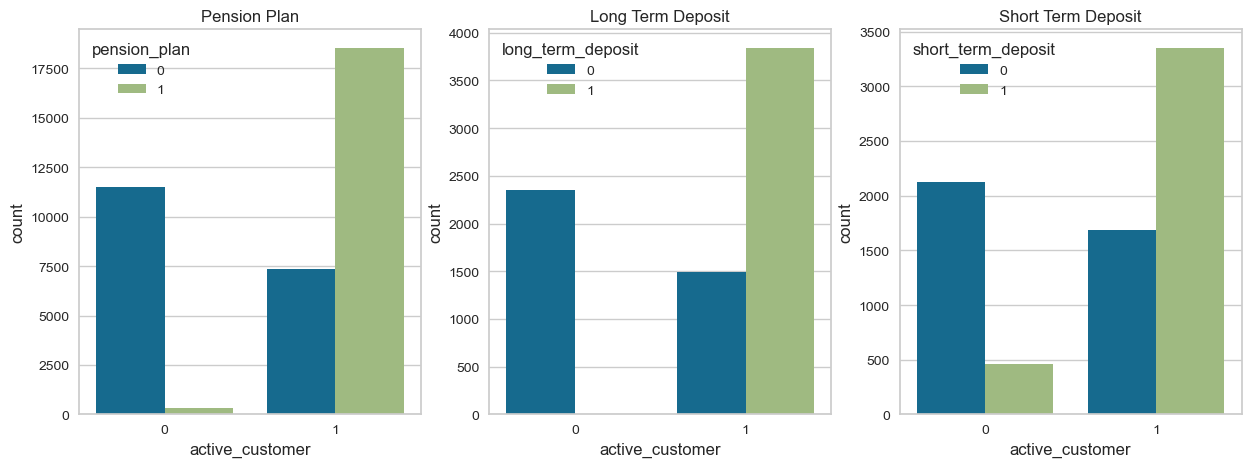

In [ ]:
# Graficación Clientes Activos vs los 3 targets
fig, (ax1, ax2, ax3)=  plt.subplots(nrows= 1, ncols=3, sharey=False, figsize= (15,5))
sns.countplot(data= df_pp_final, x= 'active_customer', hue= df_pp_final['pension_plan'], ax= ax1)
sns.countplot(data= df_lt_final, x= 'active_customer', hue= df_lt_final['long_term_deposit'], ax= ax2)
sns.countplot(data= df_st_final, x= 'active_customer', hue= df_st_final['short_term_deposit'], ax= ax3)
ax1.set_title('Pension Plan')
ax2.set_title('Long Term Deposit')
ax3.set_title('Short Term Deposit')
plt.show()

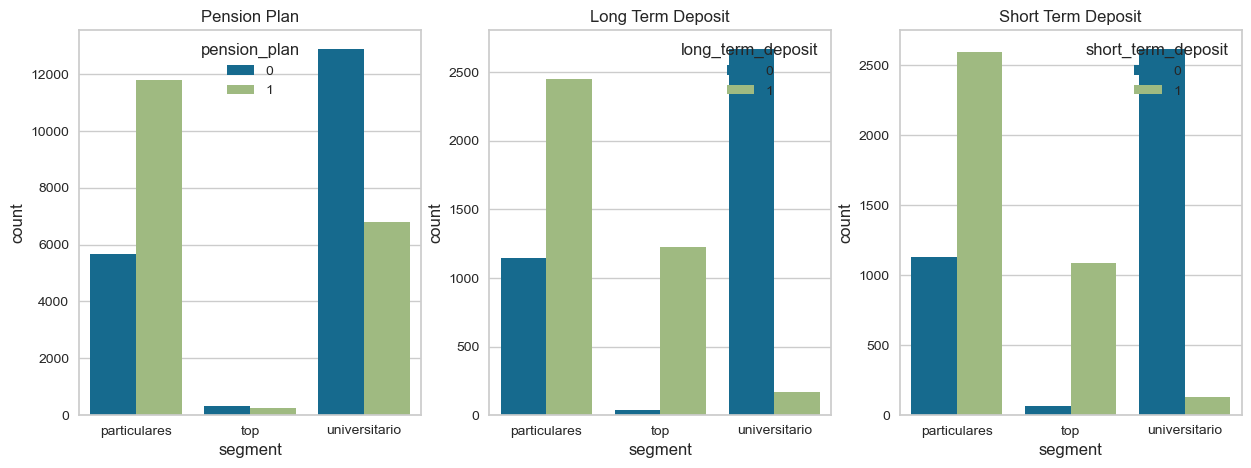

In [ ]:
# Graficación Segmentos vs los 3 targets
fig, (ax1, ax2, ax3)=  plt.subplots(nrows= 1, ncols=3, sharey=False, figsize= (15,5))
sns.countplot(data= df_pp_final, x= 'segment', hue= df_pp_final['pension_plan'], ax= ax1)
sns.countplot(data= df_lt_final, x= 'segment', hue= df_lt_final['long_term_deposit'], ax= ax2)
sns.countplot(data= df_st_final, x= 'segment', hue= df_st_final['short_term_deposit'], ax= ax3)
ax1.set_title('Pension Plan')
ax2.set_title('Long Term Deposit')
ax3.set_title('Short Term Deposit')
plt.show()

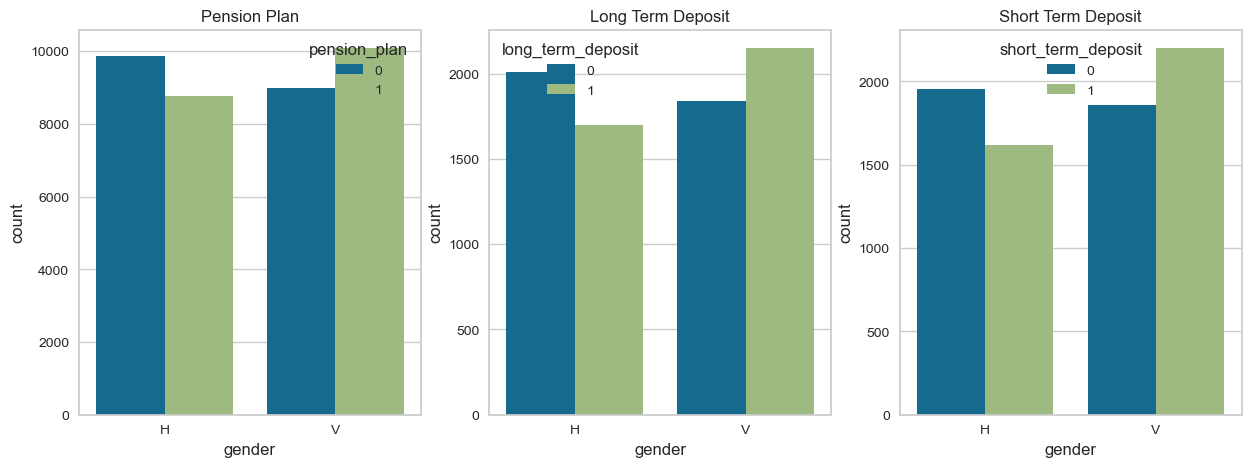

In [ ]:
# Graficación Generos vs los 3 targets
fig, (ax1, ax2, ax3)=  plt.subplots(nrows= 1, ncols=3, sharey=False, figsize= (15,5))
sns.countplot(data= df_pp_final, x= 'gender', hue= df_pp_final['pension_plan'], ax= ax1)
sns.countplot(data= df_lt_final, x= 'gender', hue= df_lt_final['long_term_deposit'], ax= ax2)
sns.countplot(data= df_st_final, x= 'gender', hue= df_st_final['short_term_deposit'], ax= ax3)
ax1.set_title('Pension Plan')
ax2.set_title('Long Term Deposit')
ax3.set_title('Short Term Deposit')
plt.show()

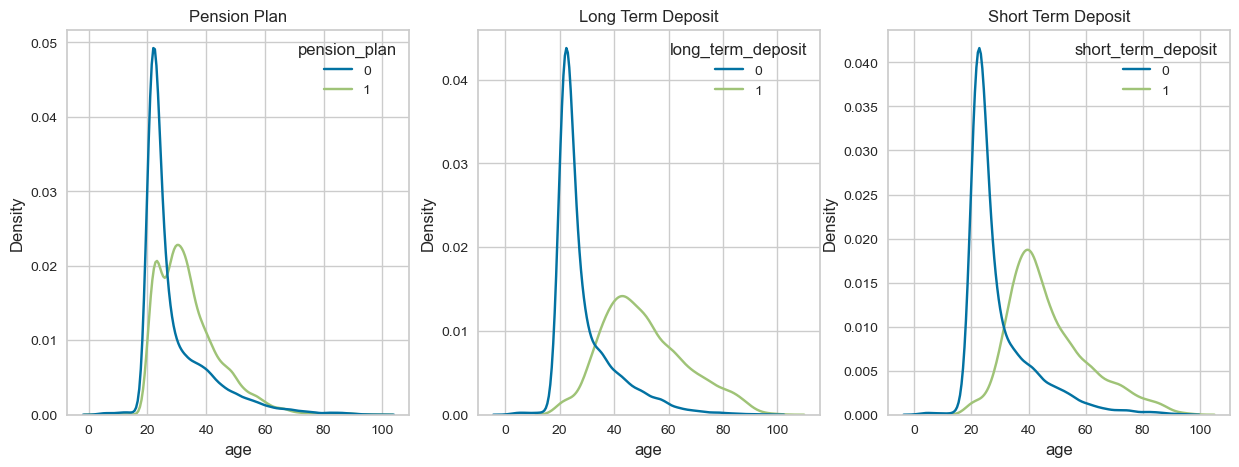

In [ ]:
# Graficación Edades vs los 3 targets
fig, (ax1, ax2, ax3)=  plt.subplots(nrows= 1, ncols=3, sharey=False, figsize= (15,5))
sns.kdeplot(data= df_pp_final, x= 'age', hue= df_pp_final['pension_plan'], ax= ax1)
sns.kdeplot(data= df_lt_final, x= 'age', hue= df_lt_final['long_term_deposit'], ax= ax2)
sns.kdeplot(data= df_st_final, x= 'age', hue= df_st_final['short_term_deposit'], ax= ax3)
ax1.set_title('Pension Plan')
ax2.set_title('Long Term Deposit')
ax3.set_title('Short Term Deposit')
plt.show()

Representación visual de la distribución de clientes según su edad separado en tres productos: Pension Plan, Long Term Deposit y Short Term Deposit. Con el objetivo de comprender rápidamente la composición demográfica de los clientes en cada grupo de edad con respecto a los productos asociados.

En la gráfica I se observa la concentración de los clientes conscientes, tanto activos como inactivos, distribuidos por edad. Se puede argumentar que los clientes activos con pensión Palan tienden a encontrarse principalmente en un rango de edades entre 20 y 40 años con una mayor concentración en los clientes con 39 años , mientras que los inactivos se concentran en un rango de edades entre 19 y 30 años.
Sugerencias: Se sugiere enfocar campañas con el objetivo de retención de clientes en el segmento Pension Plan, dirigidas específicamente a usuarios con edades comprendidas entre 19 y 40 años. Este grupo demográfico muestra una mayor propensión a abandonar el producto, por lo que resulta crucial implementar estrategias que fomenten su permanencia y satisfacción.
En la gráfica II se observa la concentración de los clientes del producto Long Term Deposit dentro del rango de edad entre 25 y 65 años con una mayor concentración en los clientes con 42 años, mientras que los clientes inactivos se concentran en un rango de edades entre 19 y 25 años.
Sugerencia: Se sugiere enfocar campañas con el objetivo de retención de clientes en el segmento Long Term Deposit, dirigidas específicamente a usuarios con edades comprendidas entre 19 y 40 años. Este grupo demográfico presenta una mayor tendencia a la inactividad, por lo que resulta crucial implementar estrategias que fomenten su compromiso y permanencia en el producto.

En la gráfica III se observa la concentración de los clientes del producto Short Term Deposit dentro del rand de edad entre 28 y 65 años con una mayor concentración en los clientes con 42 años, mientras que los clientes inactivos se concentran en un rango de edad entre 19 y 25 años.
Sugerencia: Se sugiere enfocar campañas con el objetivo de retención de clientes en el segmento Short Term Deposit, dirigidas específicamente a usuarios con edades comprendidas entre 19 y 38 años. Este grupo demográfico presenta una mayor tendencia a la inactividad, por lo que resulta crucial implementar estrategias que fomenten su compromiso y permanencia en el producto.


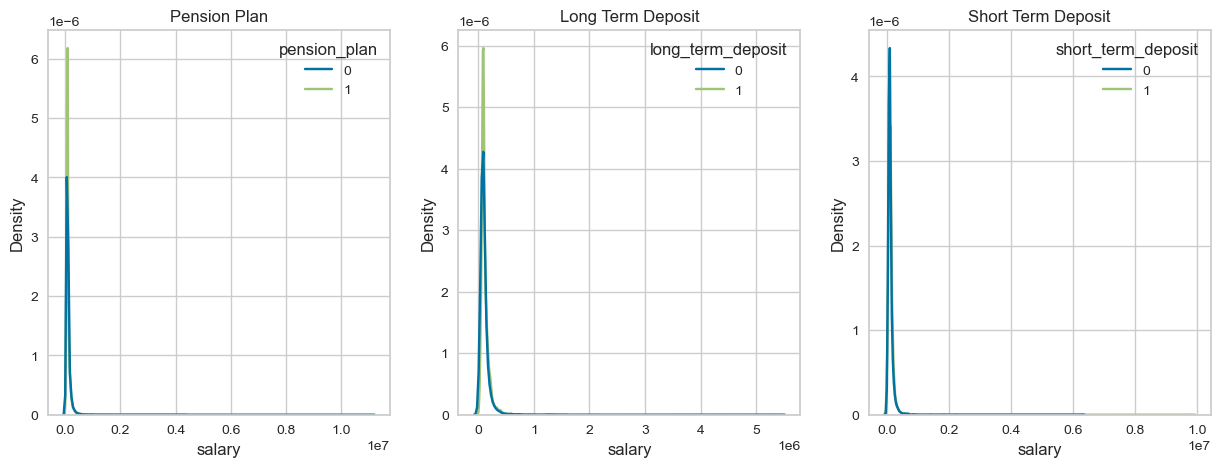

In [ ]:
# Graficación Salary vs los 3 targets
fig, (ax1, ax2, ax3)=  plt.subplots(nrows= 1, ncols=3, sharey=False, figsize= (15,5))
sns.kdeplot(data= df_pp_final, x= 'salary', hue= df_pp_final['pension_plan'], ax= ax1)
sns.kdeplot(data= df_lt_final, x= 'salary', hue= df_lt_final['long_term_deposit'], ax= ax2)
sns.kdeplot(data= df_st_final, x= 'salary', hue= df_st_final['short_term_deposit'], ax= ax3)
ax1.set_title('Pension Plan')
ax2.set_title('Long Term Deposit')
ax3.set_title('Short Term Deposit')
plt.show()

Representación visual de la distribución de clientes según sus ingresos en tres productos: Pension Plan, Long Term Deposit y Short Term Deposit. El objetivo es comprender la composición demográfica de los clientes en relación a sus niveles de ingreso y los productos asociados.

En los productos Pension Plan y Long Term Deposit, se observa una concentración de clientes en el rango salarial de 0 a 2 millones de ingresos. Sin embargo, en el producto Short Term Deposit, la distribución de clientes abarca desde 0 hasta 1.0, con una concentración más pronunciada en el intervalo de 0.0 a 0.1.

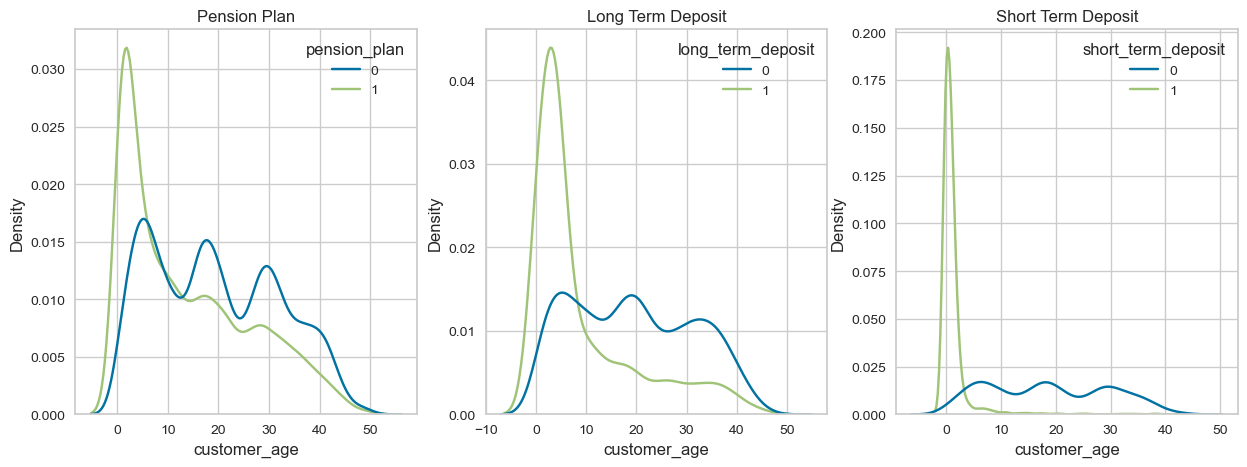

In [ ]:
# Graficación Antiguedad del cliente vs los 3 targets
fig, (ax1, ax2, ax3)=  plt.subplots(nrows= 1, ncols=3, sharey=False, figsize= (15,5))
sns.kdeplot(data= df_pp_final, x= 'customer_age', hue= df_pp_final['pension_plan'], ax= ax1)
sns.kdeplot(data= df_lt_final, x= 'customer_age', hue= df_lt_final['long_term_deposit'], ax= ax2)
sns.kdeplot(data= df_st_final, x= 'customer_age', hue= df_st_final['short_term_deposit'], ax= ax3)
ax1.set_title('Pension Plan')
ax2.set_title('Long Term Deposit')
ax3.set_title('Short Term Deposit')
plt.show()

Representación visual de la distribución de clientes según su antigüedad en tres productos: Pension Plan, Long Term Deposit y Short Term Deposit. El objetivo es comprender la composición de los clientes en relación a sus años de antigüedad  y los productos asociados.

Se puede observar que en los tres productos existe una concentración de clientes en el rango de antigüedad de 0 a 10 años. Tanto en Pension Plan como en Long Term Deposit, esta tendencia se mantiene. Sin embargo, en el caso del producto Short Term Deposit, se evidencia una distribución distinta, con una concentración más pronunciada en los primeros 0 a 8 años de antigüedad del cliente.


## Heatmap de correlación entre las features y el target

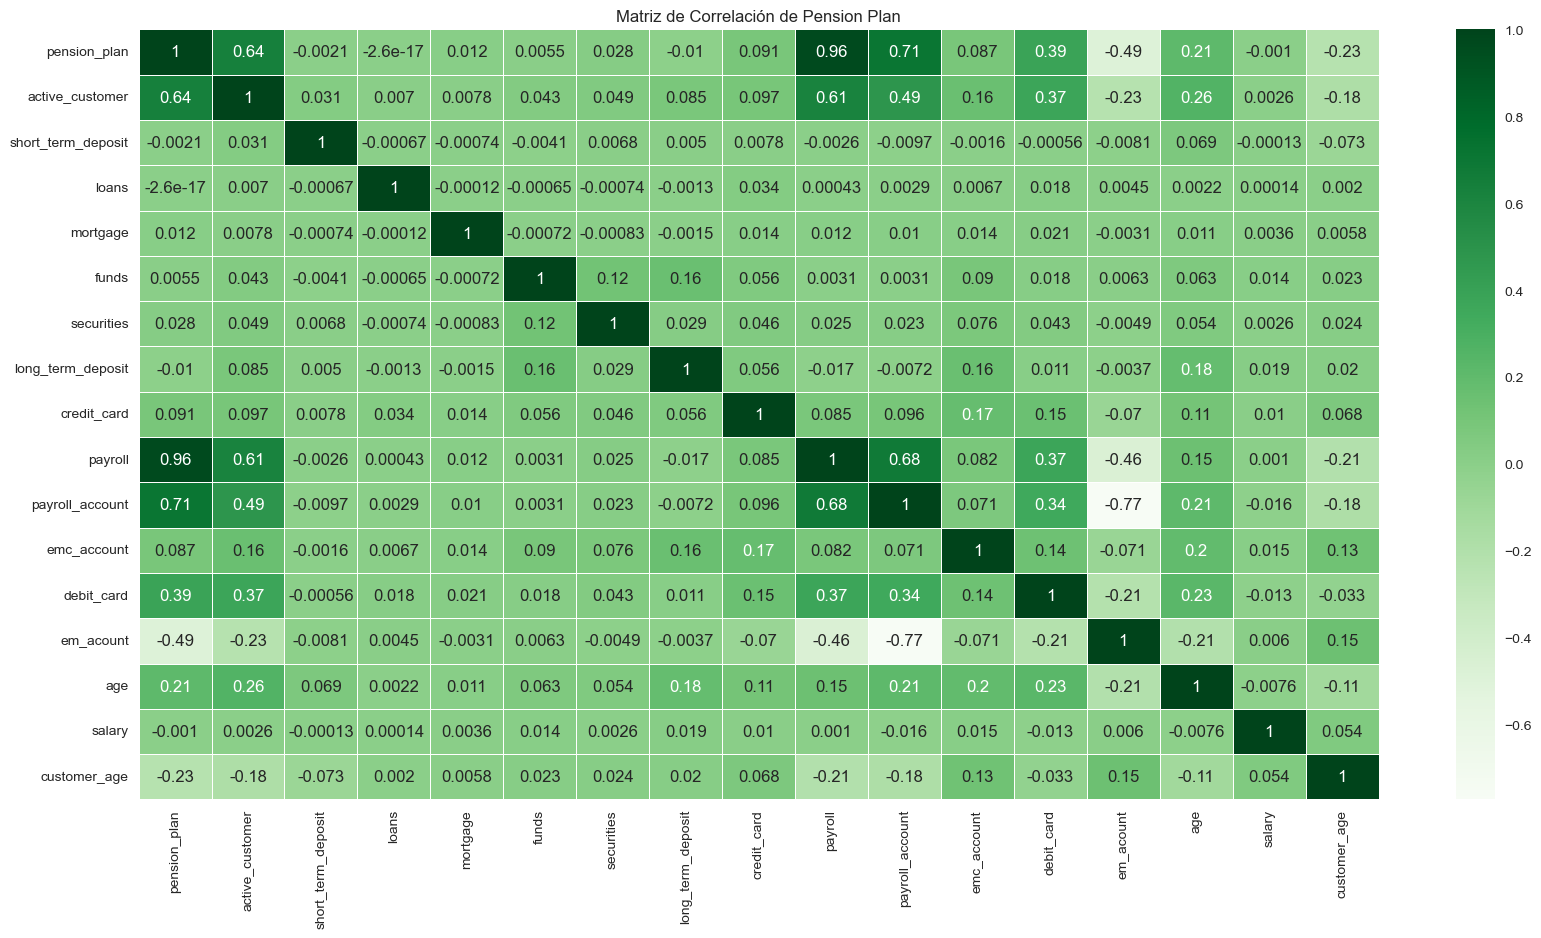

In [ ]:
# Matriz de correlacion Pension Plan
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(df_pp_final.corr(), annot=True, cmap='Greens', linewidths=0.5, linecolor='white', xticklabels=True, yticklabels=True, cbar=True).set_title('Matriz de Correlación de Pension Plan')
plt.show()

Para evitar un sobreajuste, mejorar la interpretabilidad, reducir la redundancia y reducir el costo computacional se procede a eliminar la columna de mayor correlacion como lo es **payroll** (96%)

In [ ]:
# Eliminación de columnas con muy alta correlación
df_pp_final.drop(columns= 'payroll', inplace= True)

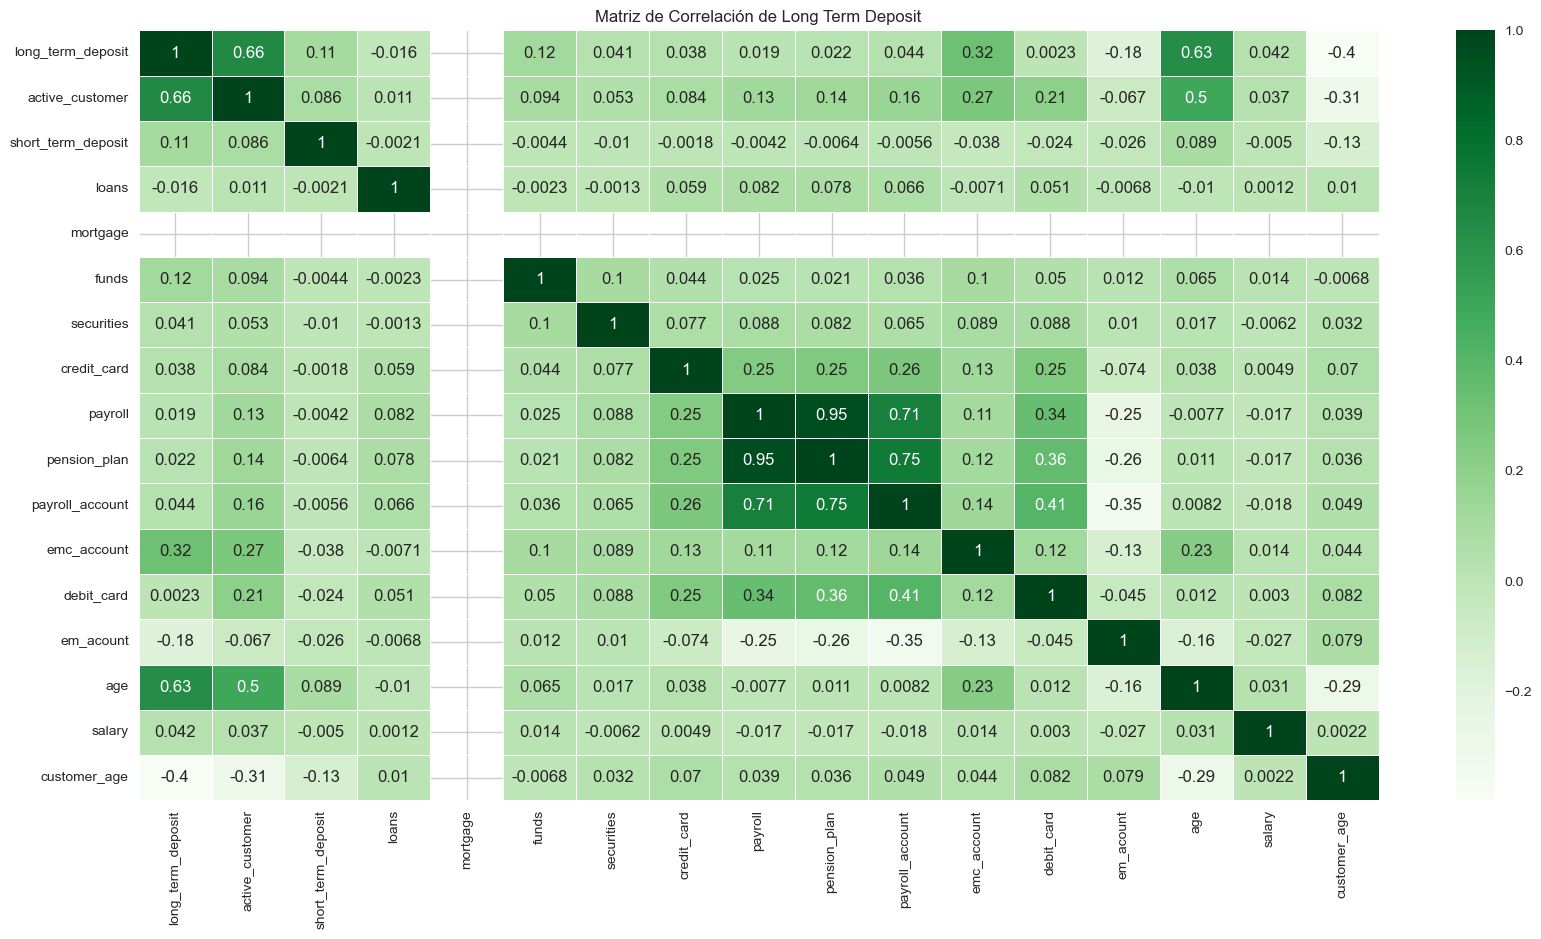

In [ ]:
# Matriz de correlación Long Term Deposit
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(df_lt_final.corr(), annot=True, cmap='Greens', linewidths=0.5, linecolor='white', xticklabels=True, yticklabels=True, cbar=True).set_title('Matriz de Correlación de Long Term Deposit')
plt.show()

Para evitar un sobreajuste, mejorar la interpretabilidad, reducir la redundancia y reducir el costo computacional se procede a eliminar una de las columnas de mayor correlación entre **payroll y pesion plan** (95%), ademas eliminar la columna de **mortgage**, ya que no aporta nada para el anilisis especifico de este producto

In [ ]:
# Eliminación de columna Loans, Mortgage y una de las columnas con muy alta correlación
df_lt_final.drop(columns= ['payroll', 'mortgage'], inplace= True)

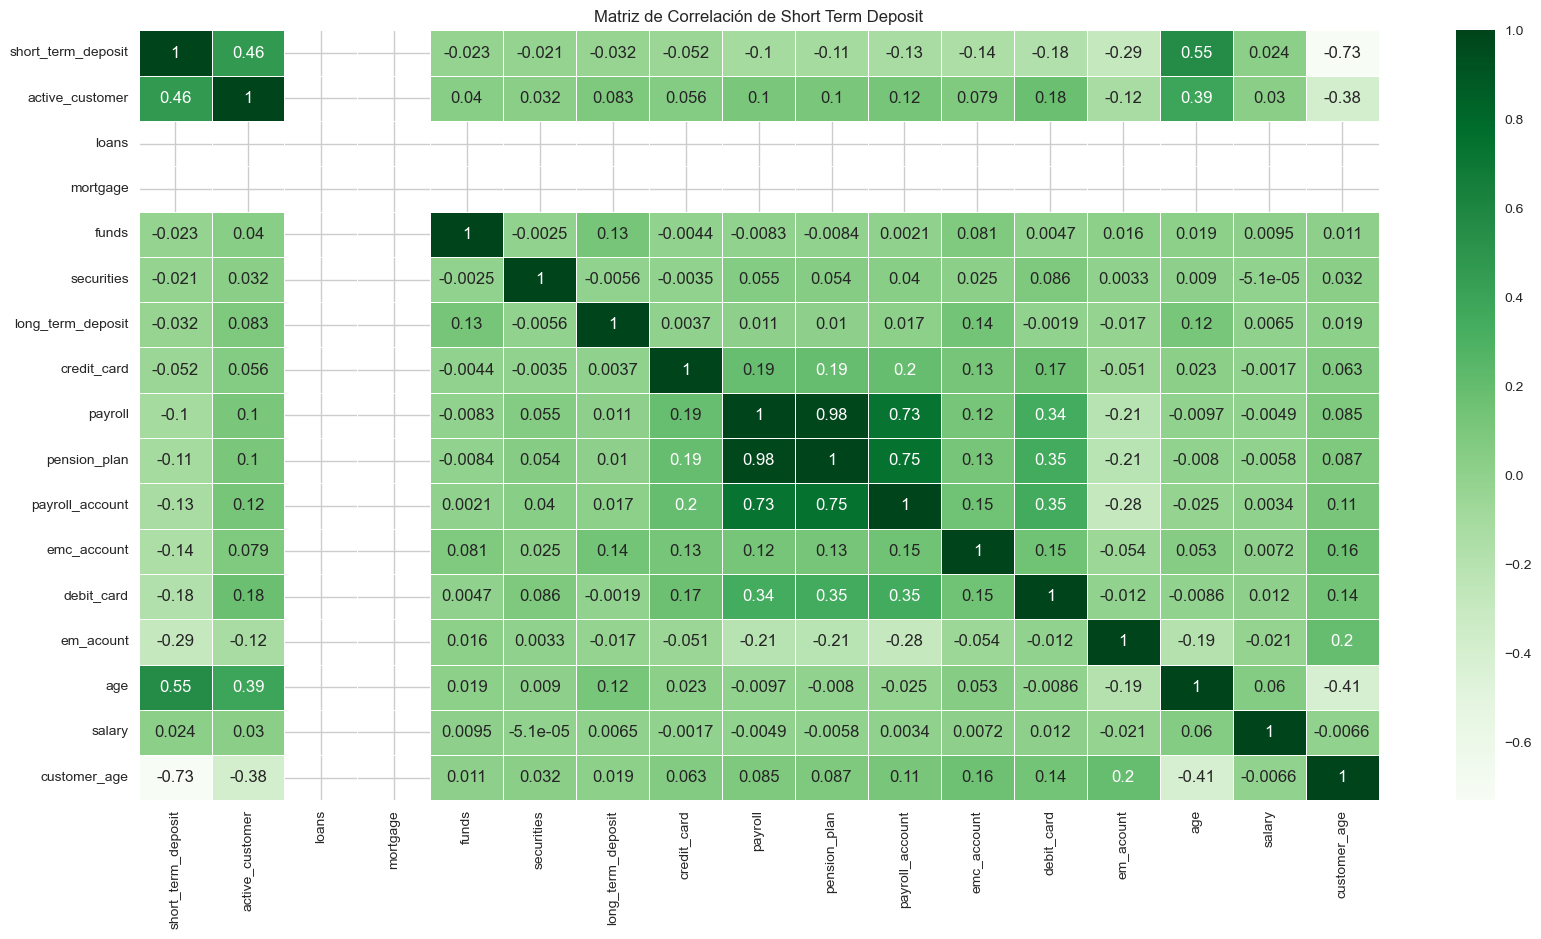

In [ ]:
# Matriz de correlación Short Term Deposit
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(df_st_final.corr(), annot=True, cmap='Greens', linewidths=0.5, linecolor='white', xticklabels=True, yticklabels=True, cbar=True).set_title('Matriz de Correlación de Short Term Deposit')
plt.show()

Para evitar un sobreajuste, mejorar la interpretabilidad, reducir la redundancia y reducir el costo computacional se procede a eliminar la columna de mayor correlacion entre **payroll y pension plan** (98%), ademas eliminar las columnas de **mortgage y loans**, ya que no aportan nada para el analisis especifico de este producto

In [ ]:
# Eliminación de columnas con muy alta correlación
df_st_final.drop(columns= ['payroll', 'mortgage', 'loans'], inplace= True)

## Aplicación de One Hot Encoding y Analisis de Varianza

In [ ]:
# Revisar info de cada Dataframe
for i in dataframes:
    print(i.info(),'\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37738 entries, 0 to 5585992
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   pension_plan        37738 non-null  int64   
 1   active_customer     37738 non-null  int64   
 2   segment             37738 non-null  category
 3   short_term_deposit  37738 non-null  int64   
 4   loans               37738 non-null  int64   
 5   mortgage            37738 non-null  int64   
 6   funds               37738 non-null  int64   
 7   securities          37738 non-null  int64   
 8   long_term_deposit   37738 non-null  int64   
 9   credit_card         37738 non-null  int64   
 10  payroll_account     37738 non-null  int64   
 11  emc_account         37738 non-null  int64   
 12  debit_card          37738 non-null  int64   
 13  em_acount           37738 non-null  int64   
 14  gender              37738 non-null  category
 15  age                 37738 non-null

In [ ]:
# Aplicación de OneHotEncoding
df_lt_final= pd.get_dummies(df_lt_final)
df_st_final= pd.get_dummies(df_st_final)
df_pp_final= pd.get_dummies(df_pp_final)

In [ ]:
# Actualización de variable con los 3 Dataframes
dataframes= [df_pp_final, df_st_final, df_lt_final]

In [ ]:
# Revisión de de aplicación de OneHotEnconding
for p in dataframes:
    print(p.columns, '\n')

Index(['pension_plan', 'active_customer', 'short_term_deposit', 'loans',
       'mortgage', 'funds', 'securities', 'long_term_deposit', 'credit_card',
       'payroll_account', 'emc_account', 'debit_card', 'em_acount', 'age',
       'salary', 'customer_age', 'segment_particulares', 'segment_top',
       'segment_universitario', 'gender_H', 'gender_V'],
      dtype='object') 

Index(['short_term_deposit', 'active_customer', 'funds', 'securities',
       'long_term_deposit', 'credit_card', 'pension_plan', 'payroll_account',
       'emc_account', 'debit_card', 'em_acount', 'age', 'salary',
       'customer_age', 'segment_particulares', 'segment_top',
       'segment_universitario', 'gender_H', 'gender_V'],
      dtype='object') 

Index(['long_term_deposit', 'active_customer', 'short_term_deposit', 'loans',
       'funds', 'securities', 'credit_card', 'pension_plan', 'payroll_account',
       'emc_account', 'debit_card', 'em_acount', 'age', 'salary',
       'customer_age', 'segment_particu

In [ ]:
df_pp_final.columns

Index(['pension_plan', 'active_customer', 'short_term_deposit', 'loans',
       'mortgage', 'funds', 'securities', 'long_term_deposit', 'credit_card',
       'payroll_account', 'emc_account', 'debit_card', 'em_acount', 'age',
       'salary', 'customer_age', 'segment_particulares', 'segment_top',
       'segment_universitario', 'gender_H', 'gender_V'],
      dtype='object')

In [ ]:
# Eliminar columnas con baja varianza para mejorar la eficiencia y la precisión de los modelos
dataframes_names = ['df_long_term_final', 'df_short_term_final', 'df_pension_plan_final']

for idx, dataframe in enumerate(dataframes):
    threshold = 0.01
    variance = dataframe.var()
    low_variance_columns = variance[variance < threshold].index
    print(f'Columnas de {dataframes_names[idx]} con baja varianza: {low_variance_columns}')
    print('******************************************************************************')
    #dataframe.drop(columns= low_variance_columns, inplace=True)
    print(dataframe.columns, '\n')

Columnas de df_long_term_final con baja varianza: Index(['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities'], dtype='object')
******************************************************************************
Index(['pension_plan', 'active_customer', 'short_term_deposit', 'loans',
       'mortgage', 'funds', 'securities', 'long_term_deposit', 'credit_card',
       'payroll_account', 'emc_account', 'debit_card', 'em_acount', 'age',
       'salary', 'customer_age', 'segment_particulares', 'segment_top',
       'segment_universitario', 'gender_H', 'gender_V'],
      dtype='object') 

Columnas de df_short_term_final con baja varianza: Index(['funds', 'securities', 'credit_card'], dtype='object')
******************************************************************************
Index(['short_term_deposit', 'active_customer', 'funds', 'securities',
       'long_term_deposit', 'credit_card', 'pension_plan', 'payroll_account',
       'emc_account', 'debit_card', 'em_acount', 'age', 'sala

## Features Importance con RandomForestClassifier

In [ ]:
# Función para iterar en cada Dataframes para visualizar cada features importante
def featuresimportance(df, target):
    """Función para crear un grafico de barra y visualizar las caracterisicas mas importantes del Dataframe"""
    # Creación de variables para features y target
    X= df.drop(columns= target)
    y= df[target]

    # Instanciar el modelo
    rf= RandomForestClassifier()

    # Entrenar modelo
    rf.fit(X, y)

    # Obtener las caracteristicas mas importantes
    importances= rf.feature_importances_
    feature_names= X.columns
    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importances = feature_importances.sort_values('Importance')

    # Graficar el modelo
    plt.figure(figsize=(20, 10))
    plt.barh(feature_importances['Feature'], feature_importances['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance {target}')
    plt.show()

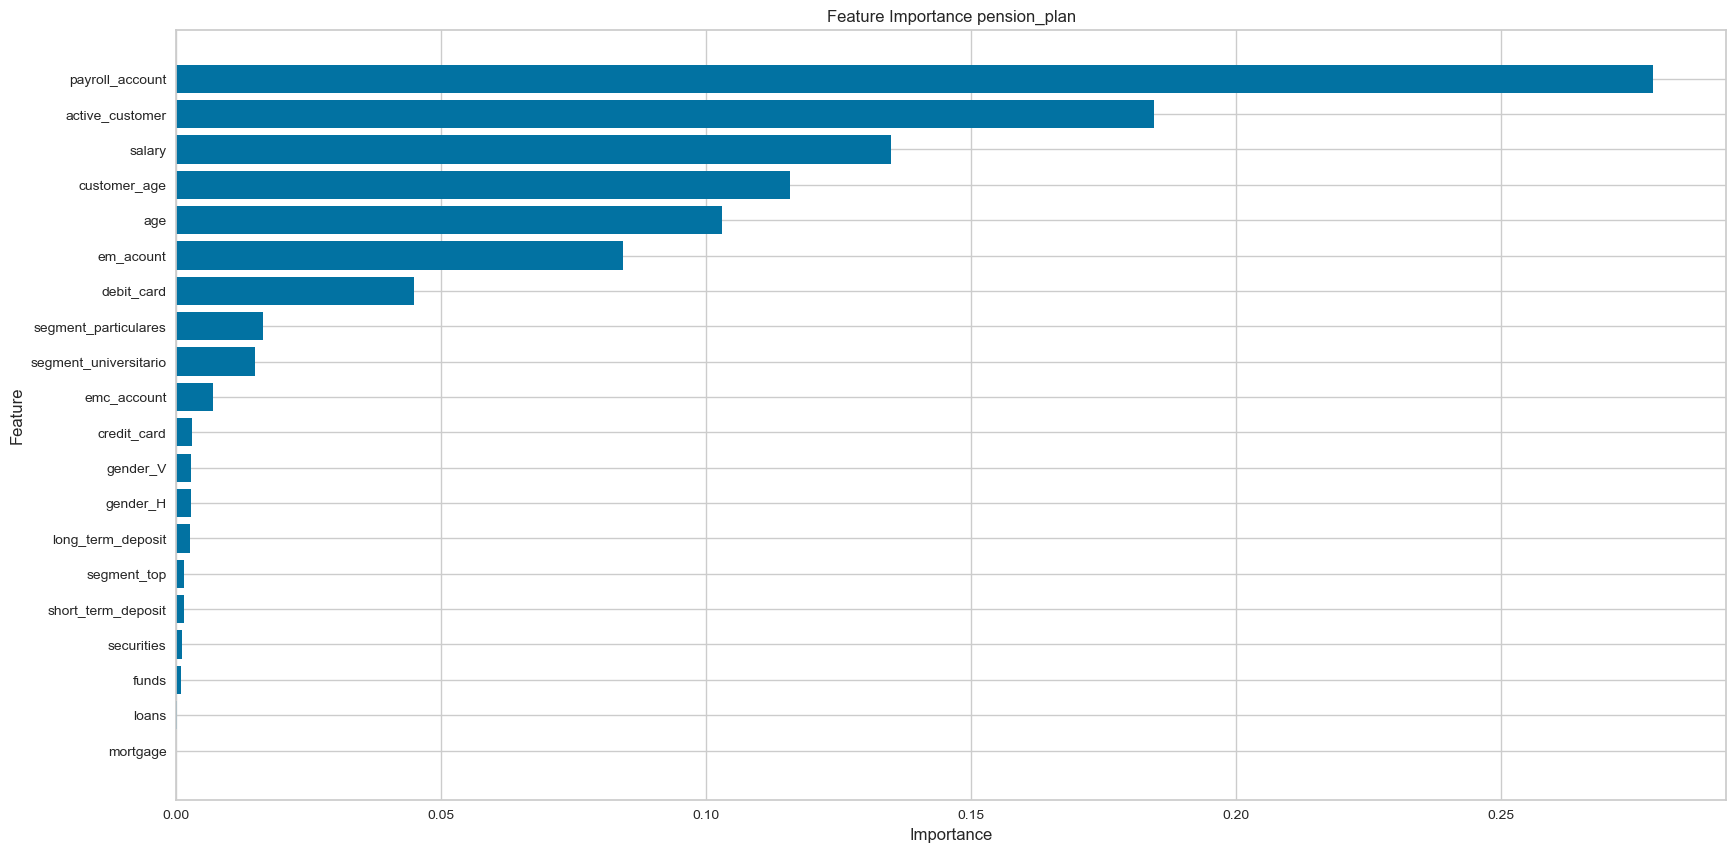

In [ ]:
featuresimportance(dataframes[0], 'pension_plan')

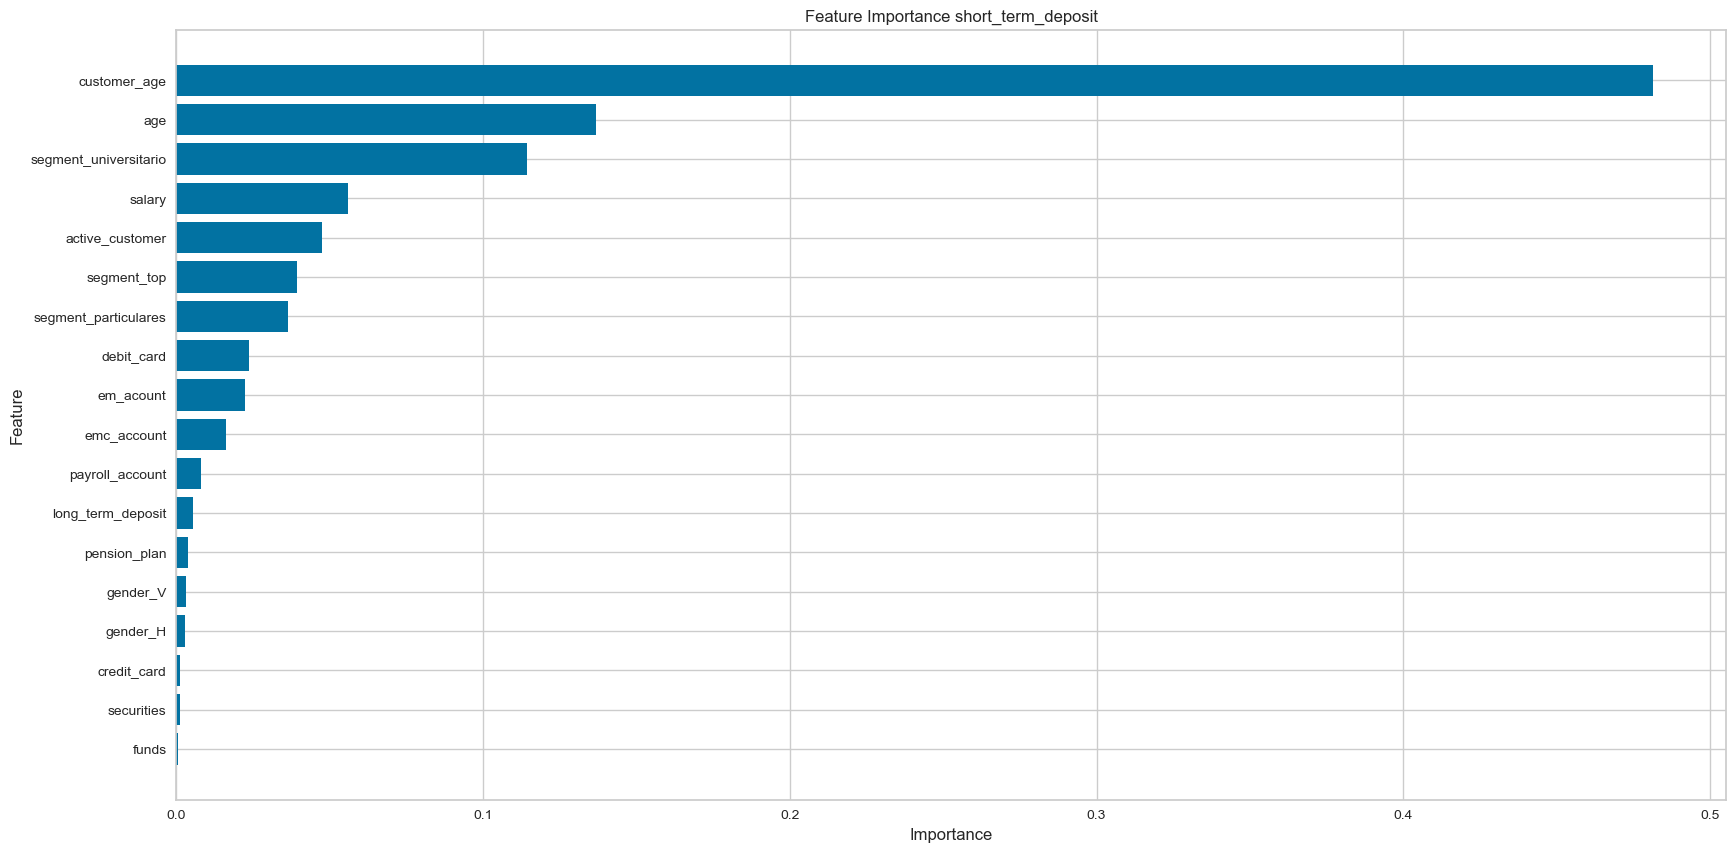

In [ ]:
featuresimportance(dataframes[1], 'short_term_deposit')

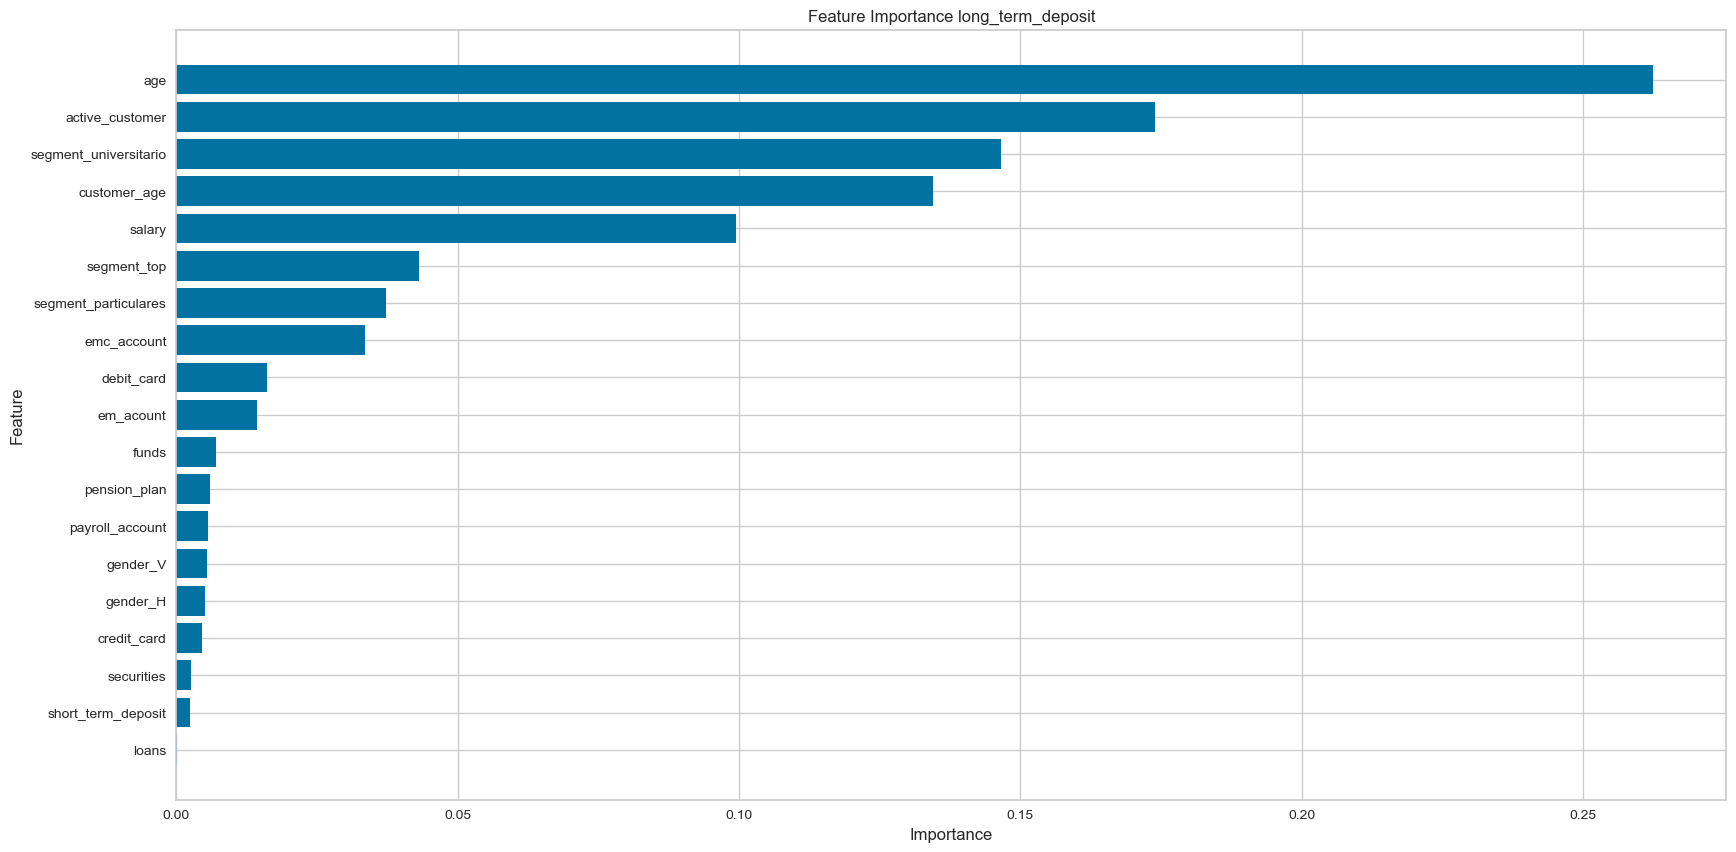

In [ ]:
featuresimportance(dataframes[2], 'long_term_deposit')

## MACHINE LEARNING

Para evitar sesgos, tener un mejor rendimiento de los algoritmos y para una interpretación mas sencilla, se estandarizaran los datos de cada uno de los productos

In [ ]:
# Dividir en datos de entrenamiento y prueba para pension_plan (70/30)
X_pp= df_pp_final.drop(columns= 'pension_plan')
y_pp= df_pp_final['pension_plan']

X_pp_train, X_pp_test, y_pp_train, y_pp_test= train_test_split(X_pp, y_pp, test_size= 0.3, random_state= 40)

In [ ]:
# Dividir en datos de entrenamiento y prueba para short_term_deposit (70/30)
X_st= df_st_final.drop(columns= 'short_term_deposit')
y_st= df_st_final['short_term_deposit']

X_st_train, X_st_test, y_st_train, y_st_test= train_test_split(X_st, y_st, test_size= 0.3, random_state= 41)

In [ ]:
# Dividir en datos de entrenamiento y prueba para long_term_deposit (70/30)
X_lt= df_lt_final.drop(columns= 'long_term_deposit')
y_lt= df_lt_final['long_term_deposit']

X_lt_train, X_lt_test, y_lt_train, y_lt_test= train_test_split(X_lt, y_lt, test_size= 0.3, random_state= 42)

In [ ]:
# Probar cada modelo de clasificación y graficar su curva ROC

def evaluate_models(X_train, X_test, y_train, y_test):
    """Función para evaluar el accuracy de cada modelo de clasificación y graficación de la curva ROC"""

    # Ingresar cada modelo con una llave-valor
    models = {
        'Logistic Regression': LogisticRegression(),
        'Support Vector Machine': SVC(probability=True, max_iter= 1000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'XGBoost': XGBClassifier()
}
    # Iterar sobre cada modelo
    for model_name, model in models.items():
        # Entrenar el modelo
        model.fit(X_train, y_train)

        # Hacer predicciones en el conjunto de prueba
        y_pred = model.predict(X_test)

        # Calcular métricas de evaluación
        accuracy = model.score(X_test, y_test)
        report = classification_report(y_test, y_pred)

        # Imprimir métricas de evaluación
        print(f"Training and evaluating {model_name}...")
        print("Accuracy:", accuracy)
        print(report)

        # Calcular la probabilidad de clase positiva para cada modelo
        probas = model.predict_proba(X_test)[:, 1]

        # Calcular la curva ROC y el AUC-ROC
        fpr, tpr, _ = roc_curve(y_test, probas)
        roc_auc = auc(fpr, tpr)

        # Graficar la curva ROC
        plt.figure()
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()

### Pension Plan

Training and evaluating Logistic Regression...
Accuracy: 0.6180886769122064
              precision    recall  f1-score   support

           0       0.62      0.59      0.60      5646
           1       0.61      0.65      0.63      5676

    accuracy                           0.62     11322
   macro avg       0.62      0.62      0.62     11322
weighted avg       0.62      0.62      0.62     11322



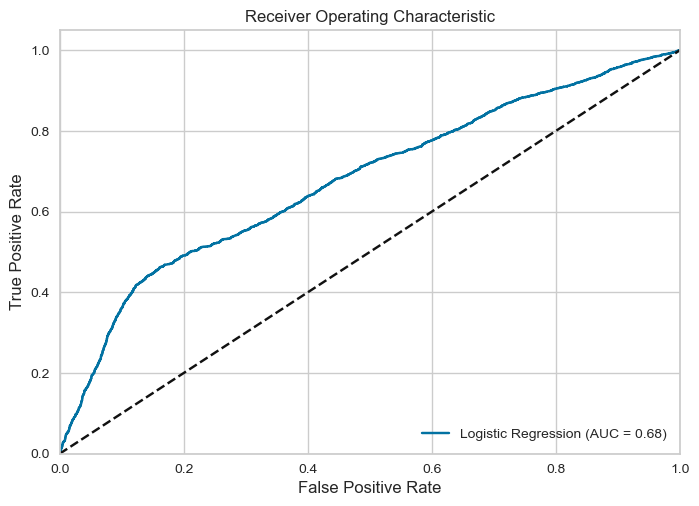

Training and evaluating Support Vector Machine...
Accuracy: 0.49920508744038156
              precision    recall  f1-score   support

           0       0.44      0.02      0.03      5646
           1       0.50      0.98      0.66      5676

    accuracy                           0.50     11322
   macro avg       0.47      0.50      0.35     11322
weighted avg       0.47      0.50      0.35     11322



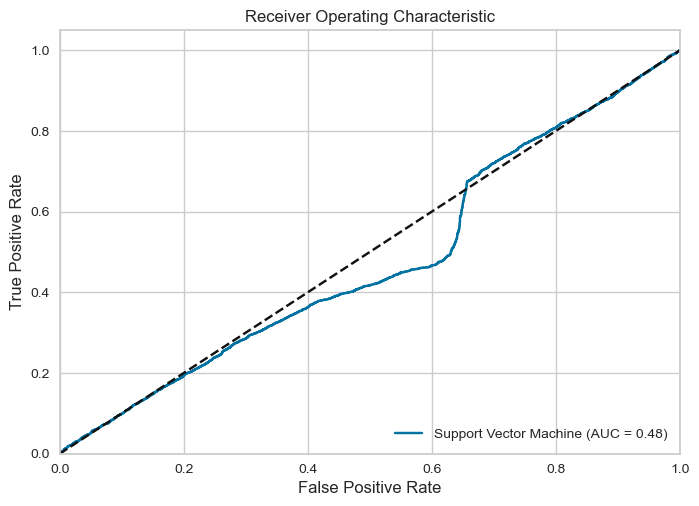

Training and evaluating Decision Tree...
Accuracy: 0.8417240770181946
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      5646
           1       0.84      0.84      0.84      5676

    accuracy                           0.84     11322
   macro avg       0.84      0.84      0.84     11322
weighted avg       0.84      0.84      0.84     11322



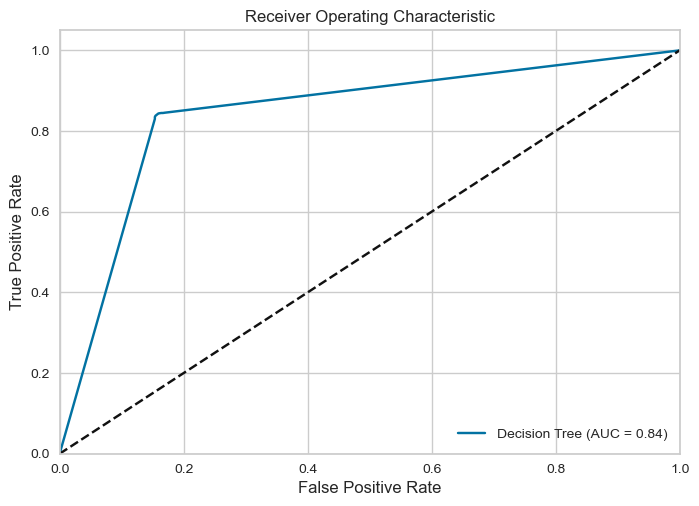

Training and evaluating Random Forest...
Accuracy: 0.8697226638403109
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5646
           1       0.87      0.87      0.87      5676

    accuracy                           0.87     11322
   macro avg       0.87      0.87      0.87     11322
weighted avg       0.87      0.87      0.87     11322



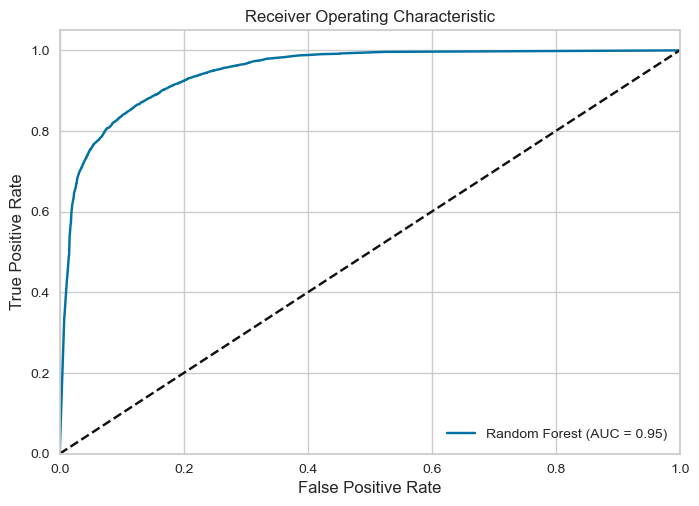

Training and evaluating Gradient Boosting...
Accuracy: 0.8810280869104399
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      5646
           1       0.90      0.86      0.88      5676

    accuracy                           0.88     11322
   macro avg       0.88      0.88      0.88     11322
weighted avg       0.88      0.88      0.88     11322



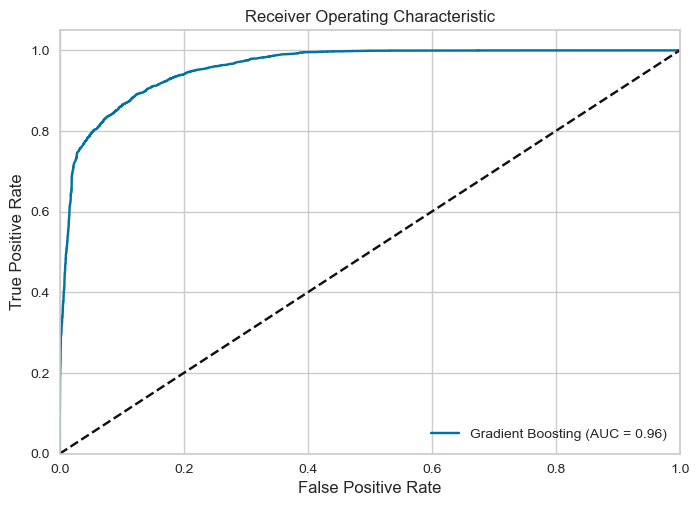

Training and evaluating XGBoost...
Accuracy: 0.8822646175587352
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      5646
           1       0.89      0.88      0.88      5676

    accuracy                           0.88     11322
   macro avg       0.88      0.88      0.88     11322
weighted avg       0.88      0.88      0.88     11322



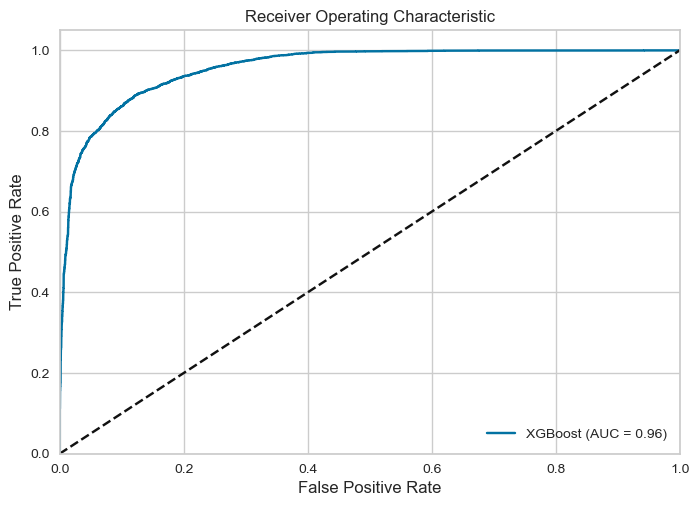

In [ ]:
# Modelar sobre Pension Plan
evaluate_models(X_pp_train, X_pp_test, y_pp_train, y_pp_test)

#### XGBoost

**Para el caso de pension plan, el modelo seleccionado debido a su buen accuracy y alto score para el AUC, sera el XGBoost.**

Hay que destarcar que el modelo de Gradient Boosting, tambien es un buen modelo para este producto, pero se eligio el otro modelo por ser uno del preferido por muchos data science y mayor ganador de concursos de Kaggle

### Short Term Deposit

Training and evaluating Logistic Regression...
Accuracy: 0.9301615015277171
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1161
           1       0.90      0.97      0.93      1130

    accuracy                           0.93      2291
   macro avg       0.93      0.93      0.93      2291
weighted avg       0.93      0.93      0.93      2291



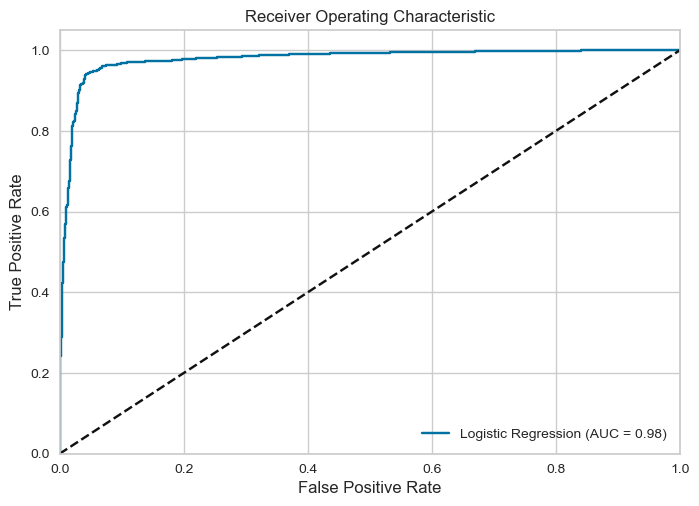

Training and evaluating Support Vector Machine...
Accuracy: 0.4936708860759494
              precision    recall  f1-score   support

           0       0.60      0.00      0.01      1161
           1       0.49      1.00      0.66      1130

    accuracy                           0.49      2291
   macro avg       0.55      0.50      0.33      2291
weighted avg       0.55      0.49      0.33      2291



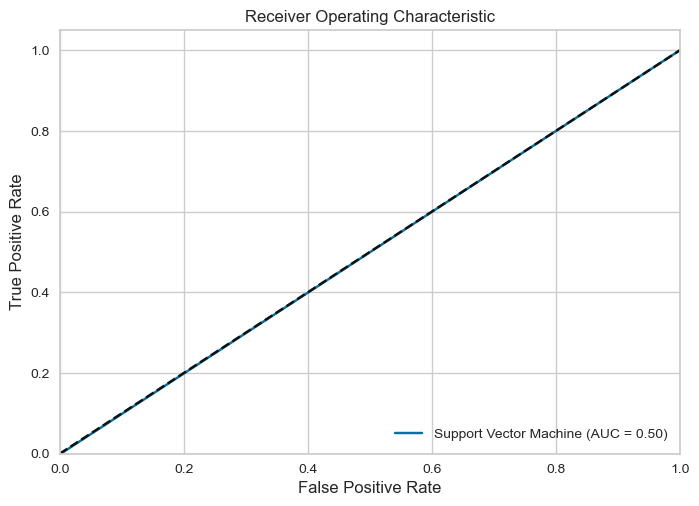

Training and evaluating Decision Tree...
Accuracy: 0.9349628982976866
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1161
           1       0.94      0.93      0.93      1130

    accuracy                           0.93      2291
   macro avg       0.94      0.93      0.93      2291
weighted avg       0.93      0.93      0.93      2291



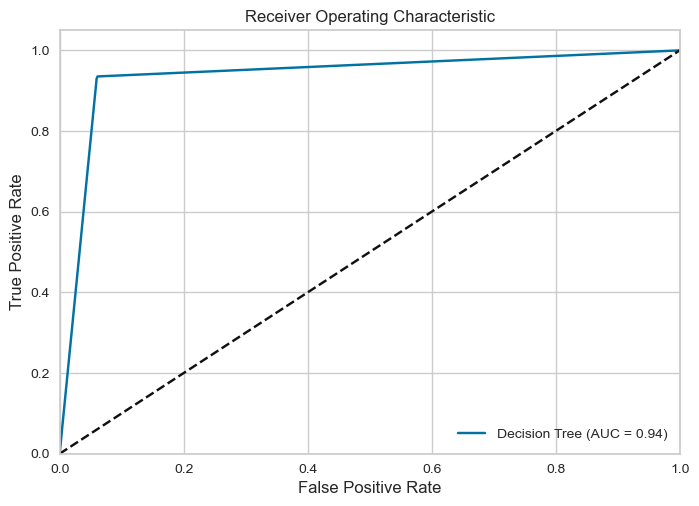

Training and evaluating Random Forest...
Accuracy: 0.9602793539938891
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1161
           1       0.96      0.96      0.96      1130

    accuracy                           0.96      2291
   macro avg       0.96      0.96      0.96      2291
weighted avg       0.96      0.96      0.96      2291



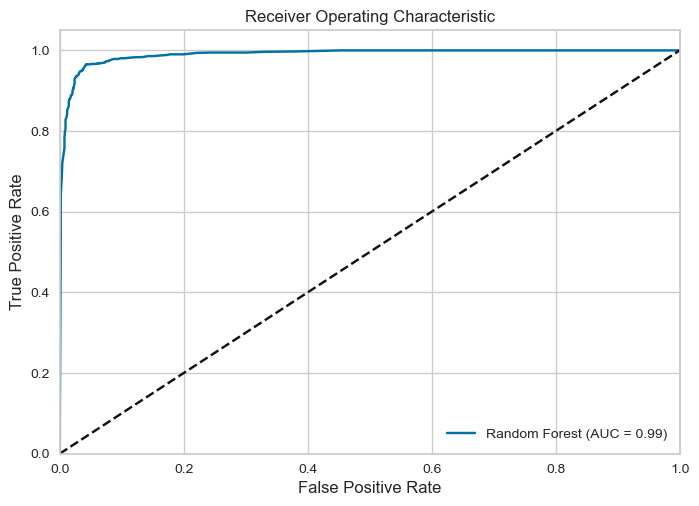

Training and evaluating Gradient Boosting...
Accuracy: 0.9637712789175032
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1161
           1       0.96      0.96      0.96      1130

    accuracy                           0.96      2291
   macro avg       0.96      0.96      0.96      2291
weighted avg       0.96      0.96      0.96      2291



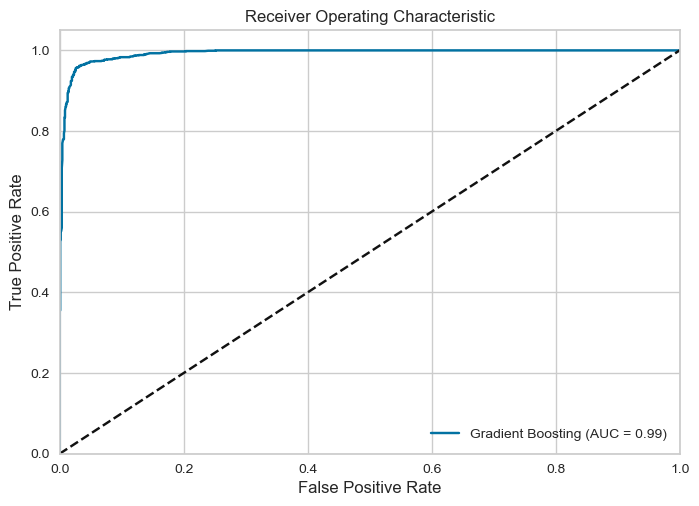

Training and evaluating XGBoost...
Accuracy: 0.9580969009166302
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1161
           1       0.95      0.96      0.96      1130

    accuracy                           0.96      2291
   macro avg       0.96      0.96      0.96      2291
weighted avg       0.96      0.96      0.96      2291



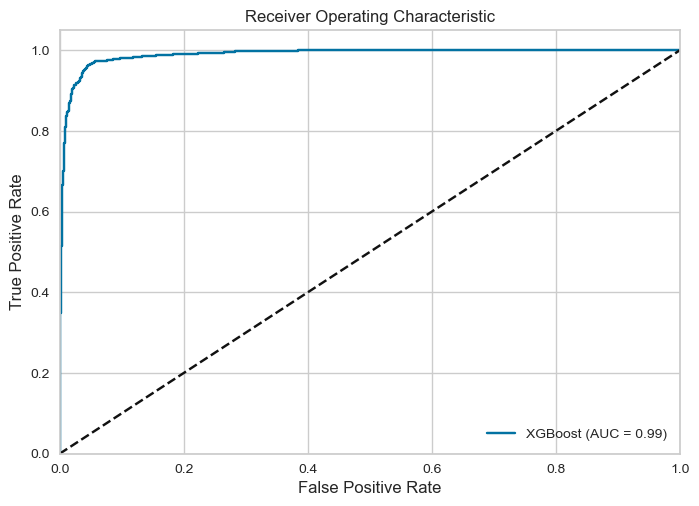

In [ ]:
# Modelar sobre Short Term Deposit
evaluate_models(X_st_train, X_st_test, y_st_train, y_st_test)

#### Gradient Boosting

**Para este producto tenemos 3 modelos con muy buen comportamiento Random Forest, XGBoost y Gradient Boosting, siendo este último el ganador por su accuracy, aunque es muy leve la diferencia**

### Long Term Deposit

Training and evaluating Logistic Regression...
Accuracy: 0.747076656561282
              precision    recall  f1-score   support

           0       0.78      0.68      0.73      1145
           1       0.72      0.81      0.76      1164

    accuracy                           0.75      2309
   macro avg       0.75      0.75      0.75      2309
weighted avg       0.75      0.75      0.75      2309



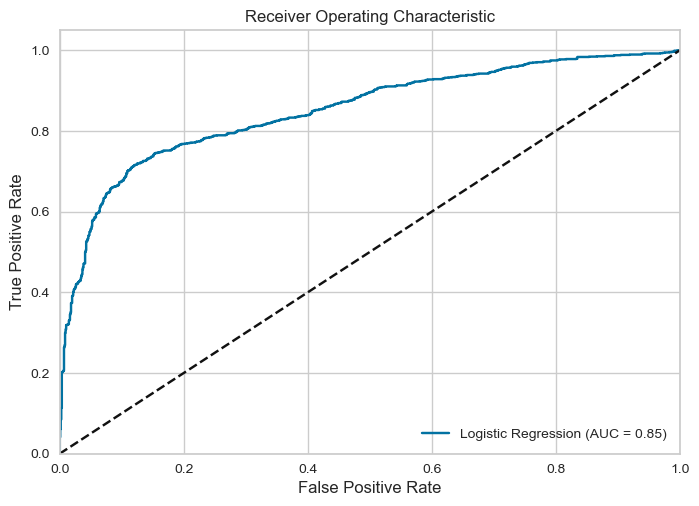

Training and evaluating Support Vector Machine...
Accuracy: 0.498051104374188
              precision    recall  f1-score   support

           0       0.45      0.05      0.09      1145
           1       0.50      0.94      0.65      1164

    accuracy                           0.50      2309
   macro avg       0.47      0.49      0.37      2309
weighted avg       0.47      0.50      0.37      2309



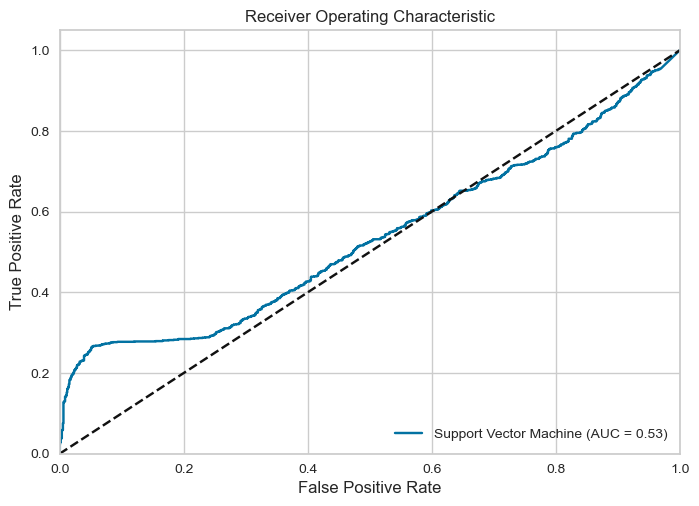

Training and evaluating Decision Tree...
Accuracy: 0.855348635773062
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1145
           1       0.86      0.85      0.86      1164

    accuracy                           0.86      2309
   macro avg       0.86      0.86      0.86      2309
weighted avg       0.86      0.86      0.86      2309



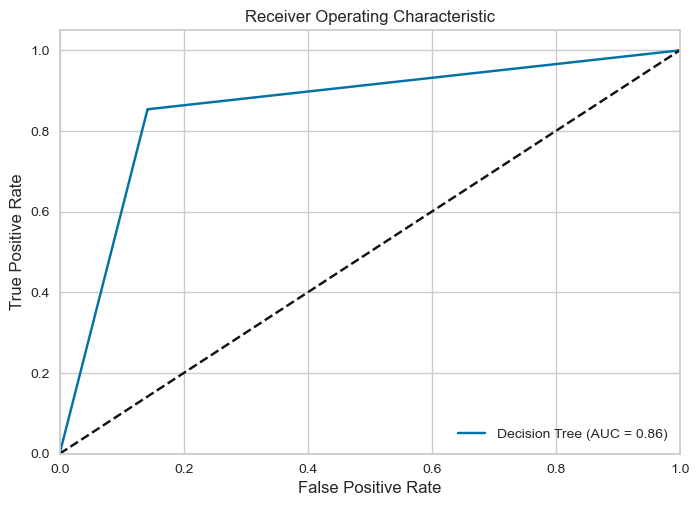

Training and evaluating Random Forest...
Accuracy: 0.895625812039844
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1145
           1       0.88      0.92      0.90      1164

    accuracy                           0.90      2309
   macro avg       0.90      0.90      0.90      2309
weighted avg       0.90      0.90      0.90      2309



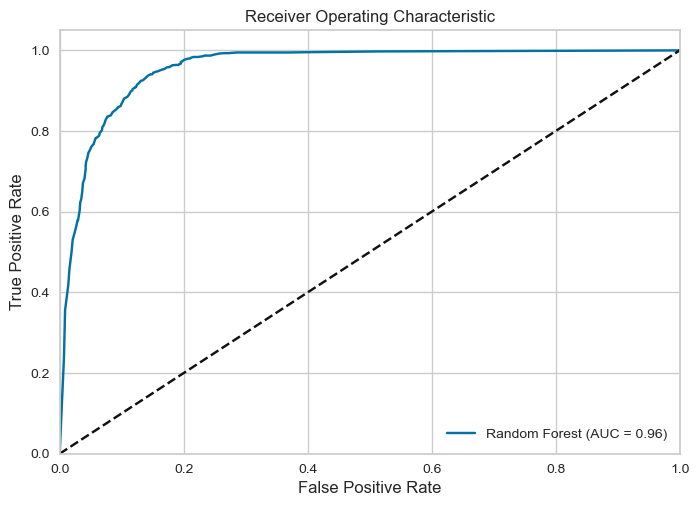

Training and evaluating Gradient Boosting...
Accuracy: 0.9055868341273279
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1145
           1       0.88      0.94      0.91      1164

    accuracy                           0.91      2309
   macro avg       0.91      0.91      0.91      2309
weighted avg       0.91      0.91      0.91      2309



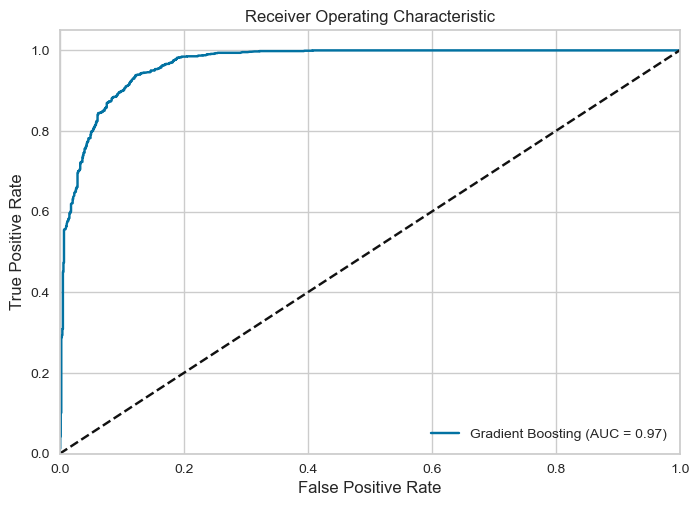

Training and evaluating XGBoost...
Accuracy: 0.8912949328713728
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1145
           1       0.88      0.91      0.89      1164

    accuracy                           0.89      2309
   macro avg       0.89      0.89      0.89      2309
weighted avg       0.89      0.89      0.89      2309



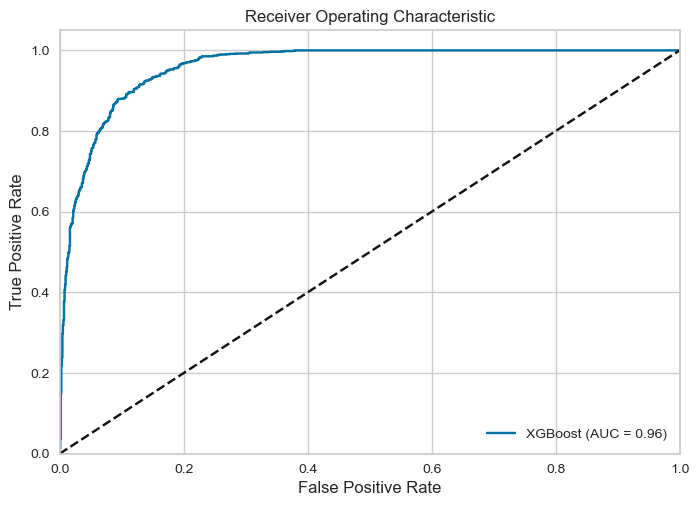

In [ ]:
# Modelar sobre Long Term Deposit
evaluate_models(X_lt_train, X_lt_test, y_lt_train, y_lt_test)

#### Gradient Boosting

**Nuevamente Gradient Boosting es el modelo con el mejor accuracy y buen score AUC, ademas de su muy buena precision y buen recall**

## Creación de lista de clientes activos del último mes registrado

In [ ]:
# Crear DF cliente activo del ultimo mes
df_last_month= df_sf[(df_sf['pk_partition'] == '2019-05-01') & (df_sf['active_customer'] == 1)]
df_last_month.head()

,pk_cid,pk_partition,entry_date,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,...,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,gender,age,salary,customer_age
5519929,657826,2019-05-01,2015-05-01,1,particulares,0,0,0,0,0,...,0,0,0,0,0,1,H,44,54493.38,48
5519931,657986,2019-05-01,2016-02-01,1,particulares,0,0,0,0,0,...,1,1,1,1,0,0,H,39,100993.17,38
5519932,657905,2019-05-01,2017-02-01,1,top,0,0,0,0,0,...,0,0,0,0,0,1,H,85,154059.09,26
5519933,657336,2019-05-01,2019-03-01,1,particulares,0,0,0,0,0,...,0,0,0,0,0,1,V,38,88446.69,2
5519935,658184,2019-05-01,2015-05-01,1,particulares,0,0,0,0,0,...,1,1,1,1,0,0,V,42,183036.72,48


In [ ]:
# Separar a clientes según el producto aún no adquirido
df_pp_predict= df_last_month[df_last_month['pension_plan'] == 0]
df_st_predict= df_last_month[df_last_month['short_term_deposit'] == 0]
df_lt_predict= df_last_month[df_last_month['long_term_deposit'] == 0]

In [ ]:
# Get dummies en los nuevos DF
df_pp_predict= pd.get_dummies(df_pp_predict)
df_st_predict= pd.get_dummies(df_st_predict)
df_lt_predict= pd.get_dummies(df_lt_predict)

In [ ]:
df_pp_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152613 entries, 5519929 to 5962921
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   pk_cid                 152613 non-null  int64         
 1   pk_partition           152613 non-null  datetime64[ns]
 2   entry_date             152613 non-null  datetime64[ns]
 3   active_customer        152613 non-null  int64         
 4   short_term_deposit     152613 non-null  int64         
 5   loans                  152613 non-null  int64         
 6   mortgage               152613 non-null  int64         
 7   funds                  152613 non-null  int64         
 8   securities             152613 non-null  int64         
 9   long_term_deposit      152613 non-null  int64         
 10  credit_card            152613 non-null  int64         
 11  payroll                152613 non-null  int64         
 12  pension_plan           152613 non-nul

In [ ]:
# Función para igualar columnas donde se hizo el entrenamiento a donde se haran las predicciones
def eliminar_columnas_no_presentes(df_predict, df_final):
    columnas_comunes = df_predict.columns.intersection(df_final.columns)
    df1_filtrado = df_predict[columnas_comunes]
    return df1_filtrado

#### Propensión para pension plan de clientes del último mes

In [ ]:
# Crear variable para predicciones de pension plan
df_pp_predict= eliminar_columnas_no_presentes(df_pp_predict, df_pp_final)
df_pp_predict= df_pp_predict.drop(columns= 'pension_plan')
df_pp_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152613 entries, 5519929 to 5962921
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   active_customer        152613 non-null  int64  
 1   short_term_deposit     152613 non-null  int64  
 2   loans                  152613 non-null  int64  
 3   mortgage               152613 non-null  int64  
 4   funds                  152613 non-null  int64  
 5   securities             152613 non-null  int64  
 6   long_term_deposit      152613 non-null  int64  
 7   credit_card            152613 non-null  int64  
 8   payroll_account        152613 non-null  int64  
 9   emc_account            152613 non-null  int64  
 10  debit_card             152613 non-null  int64  
 11  em_acount              152613 non-null  int64  
 12  age                    152613 non-null  int64  
 13  salary                 152613 non-null  float64
 14  customer_age           152613

In [ ]:
# Instanciar modelo
xgb= XGBClassifier()

# Ajustar modelo
xgb.fit(X_pp_train, y_pp_train)

# Hacer predicciones
pred_pp= xgb.predict(df_pp_predict)

# Agregar predicciones al DF
df_pp_predict["pension_plan_predict"]= pred_pp
df_pp_predict

,active_customer,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll_account,emc_account,...,em_acount,age,salary,customer_age,segment_particulares,segment_top,segment_universitario,gender_H,gender_V,pension_plan_predict
5519929,1,0,0,0,0,0,0,0,0,0,...,1,44,54493.38,48,1,0,0,1,0,0
5519932,1,0,0,0,0,0,1,0,0,0,...,1,85,154059.09,26,0,1,0,1,0,0
5519933,1,0,0,0,0,0,0,0,0,0,...,1,38,88446.69,2,1,0,0,0,1,1
5519936,1,0,0,0,0,0,1,0,0,0,...,0,78,81977.58,23,0,1,0,1,0,0
5519937,1,0,0,0,0,0,0,0,0,0,...,1,37,88446.69,4,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962895,1,0,0,0,0,0,0,0,0,0,...,1,23,88446.69,32,0,0,1,1,0,0
5962905,1,0,0,0,0,0,0,0,0,0,...,1,23,57302.85,32,0,0,1,0,1,0
5962906,1,0,0,0,0,0,0,0,0,0,...,1,23,88446.69,32,0,0,1,0,1,0
5962909,1,0,0,0,0,0,0,0,0,0,...,1,23,77784.78,32,0,0,1,0,1,0


#### Propensión para Short Term Deposit de clientes del último mes

In [ ]:
# Crear variable para predicciones de pension plan
df_st_predict= eliminar_columnas_no_presentes(df_st_predict, df_st_final)
df_st_predict= df_st_predict.drop(columns= 'short_term_deposit')
df_st_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169900 entries, 5519929 to 5962921
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   active_customer        169900 non-null  int64  
 1   funds                  169900 non-null  int64  
 2   securities             169900 non-null  int64  
 3   long_term_deposit      169900 non-null  int64  
 4   credit_card            169900 non-null  int64  
 5   pension_plan           169900 non-null  int64  
 6   payroll_account        169900 non-null  int64  
 7   emc_account            169900 non-null  int64  
 8   debit_card             169900 non-null  int64  
 9   em_acount              169900 non-null  int64  
 10  age                    169900 non-null  int64  
 11  salary                 169900 non-null  float64
 12  customer_age           169900 non-null  int64  
 13  segment_particulares   169900 non-null  uint8  
 14  segment_top            169900

In [ ]:
# Instanciar modelo
gradient_st= GradientBoostingClassifier()

# Ajustar modelo
gradient_st.fit(X_st_train, y_st_train)

# Hacer predicciones
pred_st= gradient_st.predict(df_st_predict)

# Agregar predicciones al DF
df_st_predict["short_term_predict"]= pred_st
df_st_predict

,active_customer,funds,securities,long_term_deposit,credit_card,pension_plan,payroll_account,emc_account,debit_card,em_acount,age,salary,customer_age,segment_particulares,segment_top,segment_universitario,gender_H,gender_V,short_term_predict
5519929,1,0,0,0,0,0,0,0,0,1,44,54493.38,48,1,0,0,1,0,0
5519931,1,0,0,0,1,1,1,1,1,0,39,100993.17,38,1,0,0,1,0,0
5519932,1,0,0,1,0,0,0,0,0,1,85,154059.09,26,0,1,0,1,0,0
5519933,1,0,0,0,0,0,0,0,0,1,38,88446.69,2,1,0,0,0,1,1
5519935,1,0,0,0,1,1,1,1,1,0,42,183036.72,48,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962895,1,0,0,0,0,0,0,0,0,1,23,88446.69,32,0,0,1,1,0,0
5962905,1,0,0,0,0,0,0,0,0,1,23,57302.85,32,0,0,1,0,1,0
5962906,1,0,0,0,0,0,0,0,0,1,23,88446.69,32,0,0,1,0,1,0
5962909,1,0,0,0,0,0,0,0,0,1,23,77784.78,32,0,0,1,0,1,0


#### Propensión para Long Term Deposit de clientes del último mes

In [ ]:
# Crear variable para predicciones de pension plan
df_lt_predict= eliminar_columnas_no_presentes(df_lt_predict, df_lt_final)
df_lt_predict= df_lt_predict.drop(columns= 'long_term_deposit')
df_lt_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163794 entries, 5519929 to 5962921
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   active_customer        163794 non-null  int64  
 1   short_term_deposit     163794 non-null  int64  
 2   loans                  163794 non-null  int64  
 3   funds                  163794 non-null  int64  
 4   securities             163794 non-null  int64  
 5   credit_card            163794 non-null  int64  
 6   pension_plan           163794 non-null  int64  
 7   payroll_account        163794 non-null  int64  
 8   emc_account            163794 non-null  int64  
 9   debit_card             163794 non-null  int64  
 10  em_acount              163794 non-null  int64  
 11  age                    163794 non-null  int64  
 12  salary                 163794 non-null  float64
 13  customer_age           163794 non-null  int64  
 14  segment_particulares   163794

In [ ]:
# Instanciar modelo
gradient_lt= GradientBoostingClassifier()

# Ajustar modelo
gradient_lt.fit(X_lt_train, y_lt_train)

# Hacer predicciones
pred_lt= gradient_lt.predict(df_lt_predict)

# Agregar predicciones al DF
df_lt_predict["long_term_predict"]= pred_lt
df_lt_predict

,active_customer,short_term_deposit,loans,funds,securities,credit_card,pension_plan,payroll_account,emc_account,debit_card,em_acount,age,salary,customer_age,segment_particulares,segment_top,segment_universitario,gender_H,gender_V,long_term_predict
5519929,1,0,0,0,0,0,0,0,0,0,1,44,54493.38,48,1,0,0,1,0,1
5519931,1,0,0,0,0,1,1,1,1,1,0,39,100993.17,38,1,0,0,1,0,1
5519933,1,0,0,0,0,0,0,0,0,0,1,38,88446.69,2,1,0,0,0,1,1
5519935,1,0,0,0,0,1,1,1,1,1,0,42,183036.72,48,1,0,0,0,1,0
5519937,1,0,0,0,0,0,0,0,0,0,1,37,88446.69,4,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962895,1,0,0,0,0,0,0,0,0,0,1,23,88446.69,32,0,0,1,1,0,0
5962905,1,0,0,0,0,0,0,0,0,0,1,23,57302.85,32,0,0,1,0,1,0
5962906,1,0,0,0,0,0,0,0,0,0,1,23,88446.69,32,0,0,1,0,1,0
5962909,1,0,0,0,0,0,0,0,0,0,1,23,77784.78,32,0,0,1,0,1,0


## Clustering

In [ ]:
# Crear un DF con cada uno de los clientes eliminando todos los repetidos
df_group= df_sf.drop_duplicates(subset=['pk_cid'])
df_sf.columns

Index(['pk_cid', 'pk_partition', 'entry_date', 'active_customer', 'segment',
       'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
       'long_term_deposit', 'credit_card', 'payroll', 'pension_plan',
       'payroll_account', 'emc_account', 'debit_card', 'em_account_p',
       'em_acount', 'gender', 'age', 'salary', 'customer_age'],
      dtype='object')

In [ ]:
df_group.head()

,pk_cid,pk_partition,entry_date,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,...,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,gender,age,salary,customer_age
0,1375586,2018-01-01,2018-01-01,1,particulares,0,0,0,0,0,...,0,0,0,0,0,1,H,35,87218.10,0
1,1050611,2018-01-01,2015-08-01,0,universitario,0,0,0,0,0,...,0,0,0,0,0,1,V,23,35548.74,29
2,1050612,2018-01-01,2015-08-01,0,universitario,0,0,0,0,0,...,0,0,0,0,0,1,V,23,122179.11,29
3,1050613,2018-01-01,2015-08-01,0,universitario,1,0,0,0,0,...,0,0,0,0,0,0,H,22,119775.54,29
4,1050614,2018-01-01,2015-08-01,1,universitario,0,0,0,0,0,...,0,0,0,0,0,1,V,23,88446.69,29


In [ ]:
# Separar el ID y partition de cada cliente para ingresarlos despues del clustering
df_group_cid= df_group['pk_cid']
df_group_partition= df_group['pk_partition']

In [ ]:
# Eliminación de las columnas que no suman importancia para el agrupamiento
df_group= df_group.drop(columns=['pk_cid', 'pk_partition', 'entry_date', 'payroll', 'salary'])
df_group.columns

Index(['active_customer', 'segment', 'short_term_deposit', 'loans', 'mortgage',
       'funds', 'securities', 'long_term_deposit', 'credit_card',
       'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
       'em_account_p', 'em_acount', 'gender', 'age', 'customer_age'],
      dtype='object')

In [ ]:
# Hacer uso de get dummies para que todas las columnas sean numericas
df_group= pd.get_dummies(df_group)
df_group.columns

Index(['active_customer', 'short_term_deposit', 'loans', 'mortgage', 'funds',
       'securities', 'long_term_deposit', 'credit_card', 'pension_plan',
       'payroll_account', 'emc_account', 'debit_card', 'em_account_p',
       'em_acount', 'age', 'customer_age', 'segment_particulares',
       'segment_top', 'segment_universitario', 'gender_H', 'gender_V'],
      dtype='object')

In [ ]:
# Eliminar columnas con baja varianza para mejorar la eficiencia del cluster
threshold = 0.01
variance = df_group.var()
low_variance_columns = variance[variance < threshold].index
print(f'Columnas de {df_group.columns} con baja varianza: {low_variance_columns}')
print('******************************************************************************')
df_group.drop(columns= low_variance_columns, inplace=True)
print(df_group.columns, '\n')

Columnas de Index(['active_customer', 'short_term_deposit', 'loans', 'mortgage', 'funds',
       'securities', 'long_term_deposit', 'credit_card', 'pension_plan',
       'payroll_account', 'emc_account', 'debit_card', 'em_account_p',
       'em_acount', 'age', 'customer_age', 'segment_particulares',
       'segment_top', 'segment_universitario', 'gender_H', 'gender_V'],
      dtype='object') con baja varianza: Index(['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
       'credit_card', 'em_account_p'],
      dtype='object')
******************************************************************************
Index(['active_customer', 'long_term_deposit', 'pension_plan',
       'payroll_account', 'emc_account', 'debit_card', 'em_acount', 'age',
       'customer_age', 'segment_particulares', 'segment_top',
       'segment_universitario', 'gender_H', 'gender_V'],
      dtype='object') 



In [ ]:
# Estandartizar los datos para un mejor analisis
scaler= StandardScaler()
scaler.fit(df_group)
df_scaler = pd.DataFrame(scaler.transform(df_group),columns= df_group.columns)
df_scaler

,active_customer,long_term_deposit,pension_plan,payroll_account,emc_account,debit_card,em_acount,age,customer_age,segment_particulares,segment_top,segment_universitario,gender_H,gender_V
0,1.233577,-0.115011,-0.159764,-0.192717,-0.190951,-0.266935,0.647996,0.434000,-1.019141,1.362168,-0.125172,-1.317203,0.972285,-0.972285
1,-0.810650,-0.115011,-0.159764,-0.192717,-0.190951,-0.266935,0.647996,-0.545833,1.545235,-0.734124,-0.125172,0.759184,-1.028505,1.028505
2,-0.810650,-0.115011,-0.159764,-0.192717,-0.190951,-0.266935,0.647996,-0.545833,1.545235,-0.734124,-0.125172,0.759184,-1.028505,1.028505
3,-0.810650,-0.115011,-0.159764,-0.192717,-0.190951,-0.266935,-1.543220,-0.627486,1.545235,-0.734124,-0.125172,0.759184,0.972285,-0.972285
4,1.233577,-0.115011,-0.159764,-0.192717,-0.190951,-0.266935,0.647996,-0.545833,1.545235,-0.734124,-0.125172,0.759184,-1.028505,1.028505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447415,1.233577,-0.115011,6.259217,5.188965,-0.190951,-0.266935,-1.543220,0.107389,-1.019141,1.362168,-0.125172,-1.317203,-1.028505,1.028505
447416,-0.810650,-0.115011,-0.159764,-0.192717,-0.190951,-0.266935,-1.543220,-0.382528,-1.019141,1.362168,-0.125172,-1.317203,-1.028505,1.028505
447417,1.233577,-0.115011,-0.159764,-0.192717,-0.190951,-0.266935,-1.543220,0.270695,-1.019141,1.362168,-0.125172,-1.317203,-1.028505,1.028505
447418,1.233577,-0.115011,6.259217,5.188965,-0.190951,-0.266935,-1.543220,0.107389,-1.019141,1.362168,-0.125172,-1.317203,-1.028505,1.028505


In [ ]:
# Verificación de los componentes principales para comprender la varianza
pca = PCA()
pca.fit(df_scaler)
print(pca.n_components_)

14


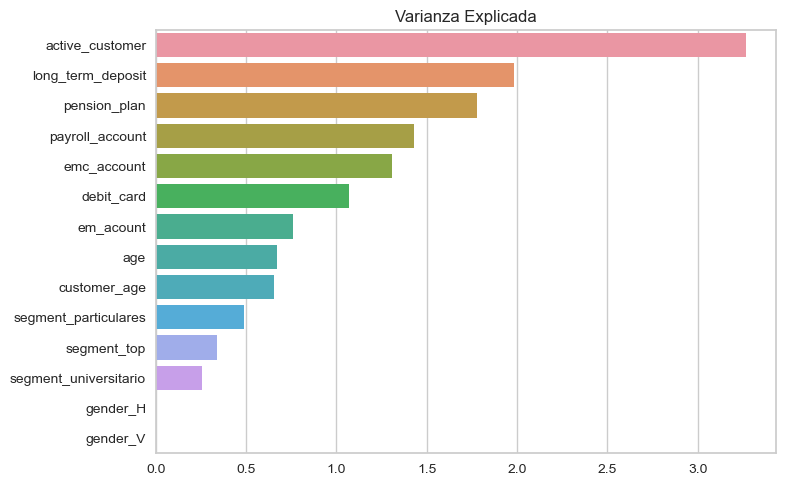

In [ ]:
# Graficación de los componentes principales para seleccionar los de mejor puntaje
sns.barplot(y= pca.feature_names_in_, x= pca.explained_variance_)
plt.title('Varianza Explicada')
plt.show()

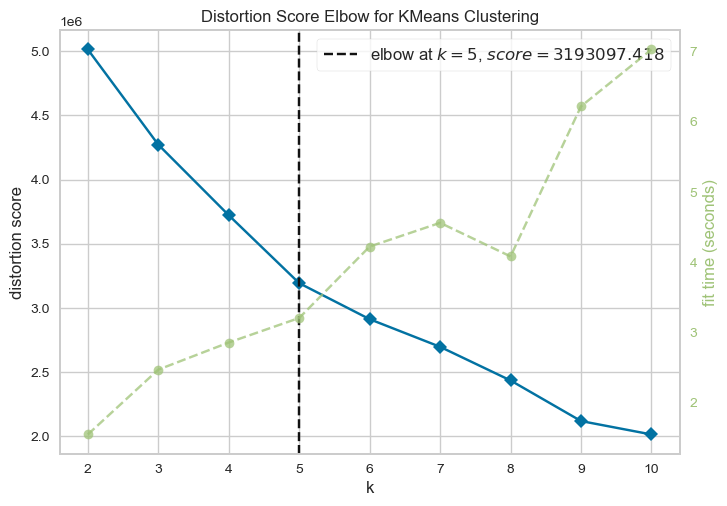

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Graficación de codo para detectar la cantidad de clusters recomendados
visualizer= KElbowVisualizer(KMeans(), k=10)
visualizer.fit(df_scaler)
visualizer.show()

In [ ]:
# Asignar cada usuario a un grupo según el analisis predictivo de Kmeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_pred = kmeans.fit_predict(df_scaler)
df_cluster = df_group.copy()
df_cluster["cluster"]= kmeans_pred
df_cluster.insert(0, 'cid', df_group_cid)
df_cluster.insert(1, 'partition', df_group_partition)
df_cluster

,cid,partition,active_customer,long_term_deposit,pension_plan,payroll_account,emc_account,debit_card,em_acount,age,customer_age,segment_particulares,segment_top,segment_universitario,gender_H,gender_V,cluster
0,1375586,2018-01-01,1,0,0,0,0,0,1,35,0,1,0,0,1,0,1
1,1050611,2018-01-01,0,0,0,0,0,0,1,23,29,0,0,1,0,1,0
2,1050612,2018-01-01,0,0,0,0,0,0,1,23,29,0,0,1,0,1,0
3,1050613,2018-01-01,0,0,0,0,0,0,0,22,29,0,0,1,1,0,2
4,1050614,2018-01-01,1,0,0,0,0,0,1,23,29,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935482,1178553,2019-05-01,1,0,1,1,0,0,0,31,0,1,0,0,0,1,3
5937531,1175116,2019-05-01,0,0,0,0,0,0,0,25,0,1,0,0,0,1,1
5947972,1185089,2019-05-01,1,0,0,0,0,0,0,33,0,1,0,0,0,1,1
5956538,1171168,2019-05-01,1,0,1,1,0,0,0,31,0,1,0,0,0,1,3


In [ ]:
df_cluster.cluster.unique()

array([1, 0, 2, 3, 4], dtype=int32)

In [ ]:
# Creación de un DF por cada cluster
df_group_0= df_cluster[df_cluster['cluster']==0]
df_group_1= df_cluster[df_cluster['cluster']==1]
df_group_2= df_cluster[df_cluster['cluster']==2]
df_group_3= df_cluster[df_cluster['cluster']==3]
df_group_4= df_cluster[df_cluster['cluster']==4]

In [ ]:
# Descripción de grupo 0
df_group_0.describe()

,cid,active_customer,long_term_deposit,pension_plan,payroll_account,emc_account,debit_card,em_acount,age,customer_age,segment_particulares,segment_top,segment_universitario,gender_H,gender_V,cluster
count,1.220340e+05,122034.000000,122034.0,122034.00000,122034.000000,122034.000000,122034.000000,122034.000000,122034.000000,122034.000000,122034.000000,122034.0,122034.000000,122034.0,122034.0,122034.0
mean,1.266659e+06,0.281184,0.0,0.00086,0.005253,0.005113,0.027869,0.789370,23.241883,12.074061,0.000008,0.0,0.999992,0.0,1.0,0.0
std,1.524181e+05,0.449579,0.0,0.02932,0.072285,0.071325,0.164599,0.407758,3.090136,11.085691,0.002863,0.0,0.002863,0.0,0.0,0.0
min,8.426300e+04,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0
25%,1.144524e+06,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,1.000000,21.000000,1.000000,0.000000,0.0,1.000000,0.0,1.0,0.0
50%,1.276592e+06,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,1.000000,22.000000,8.000000,0.000000,0.0,1.000000,0.0,1.0,0.0
75%,1.412372e+06,1.000000,0.0,0.00000,0.000000,0.000000,0.000000,1.000000,25.000000,20.000000,0.000000,0.0,1.000000,0.0,1.0,0.0
max,1.548160e+06,1.000000,0.0,1.00000,1.000000,1.000000,1.000000,1.000000,62.000000,50.000000,1.000000,0.0,1.000000,0.0,1.0,0.0


**Cluster 0 - Clientes Activos con Diversificación Financiera**


Este grupo de clientes se caracteriza por su alta participación y compromiso con la institución financiera. La mayoría de ellos posee depósitos a largo plazo, planes de pensión y cuentas de nómina, lo que refleja una planificación financiera a largo plazo y una gestión eficiente de sus ingresos. Además, muestran una adopción de servicios financieros electrónicos, como cuentas EMC y tarjetas de débito, lo cual indica su disposición a utilizar la tecnología en sus transacciones. Con una edad promedio de 37 años y una relación de cliente de casi 14 años, estos clientes demuestran una lealtad a largo plazo y una base sólida para la institución financiera. Su presencia en diferentes segmentos, junto con una distribución equilibrada por género, refuerza la diversidad y la amplia base de clientes. En resumen, estos clientes activos con diversificación financiera representan una valiosa oportunidad para el crecimiento y éxito de la institución financiera.

In [ ]:
# Descripción de grupo 1
df_group_1.describe()

,cid,active_customer,long_term_deposit,pension_plan,payroll_account,emc_account,debit_card,em_acount,age,customer_age,segment_particulares,segment_top,segment_universitario,gender_H,gender_V,cluster
count,1.436080e+05,143608.000000,143608.0,143608.000000,143608.000000,143608.000000,143608.000000,143608.000000,143608.000000,143608.000000,143608.000000,143608.0,143608.000000,143608.000000,143608.000000,143608.0
mean,1.291589e+06,0.555115,0.0,0.000063,0.012771,0.063875,0.097077,0.614297,40.209647,9.976854,0.999993,0.0,0.000007,0.426501,0.573499,1.0
std,2.063391e+05,0.496955,0.0,0.007916,0.112285,0.244531,0.296063,0.486763,13.571881,11.658666,0.002639,0.0,0.002639,0.494570,0.494570,0.0
min,1.589100e+04,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0
25%,1.156640e+06,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.0
50%,1.327080e+06,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,39.000000,4.000000,1.000000,0.0,0.000000,0.000000,1.000000,1.0
75%,1.438446e+06,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,47.000000,18.000000,1.000000,0.0,0.000000,1.000000,1.000000,1.0
max,1.548217e+06,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,104.000000,50.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.0


**Cluster 1 - Clientes Jóvenes y Universitarios**

Este grupo de clientes se caracteriza por su perfil demográfico más joven, con una edad promedio de 23 años. Son principalmente clientes activos, con una participación significativa en servicios como cuentas de ahorro, tarjetas de débito y cuentas electrónicas. Aunque tienen una baja propensión a adquirir productos de inversión a largo plazo, como depósitos a largo plazo y planes de pensión, muestran una fuerte preferencia por servicios bancarios básicos y una alta adopción de servicios electrónicos. Este grupo está compuesto principalmente por estudiantes universitarios y jóvenes profesionales en etapas tempranas de su vida financiera. Dada su juventud, existe un gran potencial para fomentar relaciones a largo plazo y ofrecer productos y servicios más complejos a medida que maduran financieramente. En resumen, los Clientes Jóvenes y Universitarios representan una valiosa oportunidad para la institución financiera en términos de captación y retención a largo plazo, así como para promover la educación financiera y la fidelidad a la marca.

In [ ]:
# Descripción de grupo 2
df_group_2.describe()

,cid,active_customer,long_term_deposit,pension_plan,payroll_account,emc_account,debit_card,em_acount,age,customer_age,segment_particulares,segment_top,segment_universitario,gender_H,gender_V,cluster
count,1.582190e+05,158219.000000,158219.0,158219.000000,158219.000000,158219.000000,158219.000000,158219.000000,158219.000000,158219.000000,158219.000000,158219.0,158219.000000,158219.0,158219.0,158219.0
mean,1.264698e+06,0.256929,0.0,0.000657,0.004475,0.003122,0.019435,0.776689,22.973625,12.259343,0.000512,0.0,0.999488,1.0,0.0,2.0
std,1.520671e+05,0.436941,0.0,0.025630,0.066744,0.055790,0.138049,0.416466,2.903961,10.990683,0.022621,0.0,0.022621,0.0,0.0,0.0
min,4.281970e+05,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.0,0.000000,1.0,0.0,2.0
25%,1.144324e+06,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,21.000000,1.000000,0.000000,0.0,1.000000,1.0,0.0,2.0
50%,1.273448e+06,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,22.000000,8.000000,0.000000,0.0,1.000000,1.0,0.0,2.0
75%,1.413750e+06,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,24.000000,20.000000,0.000000,0.0,1.000000,1.0,0.0,2.0
max,1.548140e+06,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,58.000000,43.000000,1.000000,0.0,1.000000,1.0,0.0,2.0


**Cluster 2 - Participantes Activos Tradicionales**

Este grupo de clientes se caracteriza por ser mayormente clientes activos con una alta participación en servicios bancarios básicos como cuentas de ahorro, tarjetas de débito y cuentas electrónicas. Tienen una edad promedio de aproximadamente 40 años y están clasificados en el segmento de particulares. Aunque muestran una baja propensión a adquirir productos de inversión a largo plazo, como depósitos a largo plazo y planes de pensión, presentan una preferencia por servicios bancarios más tradicionales. Este grupo está compuesto principalmente por personas de mediana edad en etapas tempranas de su vida financiera. Es importante destacar que la mayoría de los clientes en este grupo son del género femenino. En resumen, este segmento de clientes activos y de mediana edad ofrece una oportunidad para promover servicios adicionales y productos financieros a medida que desarrollan una mayor relación con la institución financiera.

In [ ]:
# Descripción de grupo 3
df_group_3.describe()

,cid,active_customer,long_term_deposit,pension_plan,payroll_account,emc_account,debit_card,em_acount,age,customer_age,segment_particulares,segment_top,segment_universitario,gender_H,gender_V,cluster
count,1.349900e+04,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.0
mean,1.198490e+06,0.975702,0.017927,0.796652,0.925476,0.219053,0.641529,0.087636,37.803837,15.121268,0.727091,0.016372,0.256538,0.461071,0.538929,3.0
std,1.914504e+05,0.153979,0.132692,0.402504,0.262632,0.413620,0.479569,0.282775,11.435164,11.024416,0.445471,0.126904,0.436738,0.498501,0.498501,0.0
min,1.797000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
25%,1.101194e+06,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,30.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
50%,1.194376e+06,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,35.000000,15.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.0
75%,1.297218e+06,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,44.000000,25.000000,1.000000,0.000000,1.000000,1.000000,1.000000,3.0
max,1.548215e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,42.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0


**Cluster 3 - Clientes Jóvenes Activos**

Estos clientes se caracterizan por ser una población enérgica y comprometida con sus finanzas. Este grupo se compone principalmente de personas jóvenes, con una edad promedio de 23 años, y se destacan por su participación activa en el uso de servicios financieros. Aunque no muestran un interés significativo en productos de depósito a largo plazo, planes de pensión o cuentas de nómina, suelen tener una alta propensión al uso de tarjetas de débito y cuentas electrónicas. Se identifican principalmente como parte del segmento de "Particulares" y muestran una preferencia hacia el género femenino. Este grupo se representa un segmento dinámico y vital en el ámbito financiero.

In [ ]:
# Descripción de grupo 4
df_group_4.describe()

,cid,active_customer,long_term_deposit,pension_plan,payroll_account,emc_account,debit_card,em_acount,age,customer_age,segment_particulares,segment_top,segment_universitario,gender_H,gender_V,cluster
count,1.006000e+04,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.0
mean,1.213396e+06,0.951491,0.556561,0.016302,0.034394,0.247714,0.067893,0.645030,52.253678,10.600795,0.316402,0.664115,0.019483,0.427833,0.572167,4.0
std,2.633237e+05,0.214850,0.496815,0.126641,0.182247,0.431706,0.251574,0.478528,15.047860,11.374355,0.465095,0.472322,0.138222,0.494789,0.494789,0.0
min,1.745700e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0
25%,1.114839e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0
50%,1.260256e+06,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,50.000000,6.000000,0.000000,1.000000,0.000000,0.000000,1.000000,4.0
75%,1.389038e+06,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,62.000000,21.000000,1.000000,1.000000,0.000000,1.000000,1.000000,4.0
max,1.547993e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,101.000000,48.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.0


**Cluster 4 - Segmento Próspero y Previsor**

El grupo está conformado por aproximadamente 10 mil individuos. Estos clientes se caracterizan por ser altamente activos y comprometidos con sus finanzas. La gran mayoría de ellos tienen depósitos a largo plazo, mientras que un 55% tiene un plan de pensión. Además, el 24% tiene una cuenta de emergencia y el 6% posee una tarjeta de débito. El rango de edad promedio en este grupo es de 52 años. Los clientes tienen una antigüedad promedio de 10 años y se identifican principalmente como parte del segmento de "Particulares". Los clientes de este grupo son de género masculino. Este grupo se encuentra clasificado en el cluster número 4, lo que indica que comparten características y comportamientos similares en el ámbito financiero. En resumen, este grupo representa clientes maduros y financieramente estables, con una amplia gama de productos y servicios financieros.

## CAMPAÑAS PARA EASYMONEY

A continuación, se presentan tres campañas diseñadas para aprovechar los clusters identificados previamente y promocionar los productos más demandados en Easymoney. Cada campaña se enfoca en un producto específico e incluye una descripción junto con su valor de mercado.

La campaña número 3 está dirigida a los cluster 0, 1 y 2, y se identifica como la campaña de mayor valor en el mercado, seguida por la campaña 2. Sin embargo, es importante destacar que el producto al que se dirige la campaña 3, es "Short Term Deposit", tiene la media de margen neto más baja de los tres, con un valor de 1,486 euros. En comparación, "Long Term Deposit" tiene una media de margen neto de 1,496 euros, y por último, "Pension Plan" que tiene una media de margen neto de 5,976 euros, siendo el producto que deja un mayor margen neto.

### **Campaña 1: "Diversifica tus finanzas"**

**Objetivo**: Promover la adquisición de productos y servicios adicionales entre los clientes de **Activos con Diversificación Financiera**.

**Mensaje**: Destaca la importancia de la diversificación financiera y cómo puede ayudar a los clientes a alcanzar sus metas financieras a largo plazo.
Oferta: Ofrece promociones especiales en cuentas EMC, tarjetas de débito y otros productos y servicios adicionales que puedan ser relevantes para este cluster.

**Descripción**: Se busca promover depósitos a largo plazo entre los clientes de Activos y Diversificados. Estos clientes tienen una variedad de productos y servicios, pero muestran poca participación en depósitos a largo plazo. También se pueden ofrecer otros productos y servicios adicionales, como cuentas de inversión y seguros de vida, para maximizar los beneficios y alcanzar metas financieras a largo plazo. Destacar la seguridad, los rendimientos y la asesoría personalizada puede ser clave en esta campaña.

Valor del mercado (Margen neto promedio * Total de clientes activos en clúster): Tiene un valor total de 182 millones de euros

In [ ]:
len(df_group_0)*df_lt_mean

182562864

### **Campaña 2: "Prepara tu futuro financiero"**

**Objetivo**: Fomentar la planificación financiera a largo plazo y el ahorro para el retiro entre los clientes de **Clientes Jóvenes Activos y Segmento Próspero y Previsor**.

**Mensaje**: Destaca los beneficios de los productos de ahorro a largo plazo y los planes de pensión, y cómo pueden ayudar a garantizar un futuro financiero estable.

**Oferta**: Brinda información detallada sobre los beneficios y características de los productos de depósitos a largo plazo y planes de pensión, y ofrece asesoramiento financiero personalizado para estos clientes.

**Descripción**: Se busca motivar a los clientes a tomar medidas proactivas para asegurar su futuro financiero, haciendo hincapié en los beneficios al Plan de Pensión. Al resaltar la importancia de comenzar a ahorrar para la jubilación lo antes posible, se busca generar conciencia sobre la necesidad de establecer una base financiera sólida y aprovechar las ventajas del plan ofrecido por la empresa financiera.

Valor del mercado (Margen neto promedio * Total de clientes activos en clúster):  Para el clúster 3 el valor del mercado con el producto Pension Plan es de 80 millones de euros y para el cuarto clúster el valor es de 60 millones de euros, ambos clústers tienen un valor total de 140 millones de euros.

In [ ]:
print(len(df_group_3)*df_pp_mean)
print(len(df_group_4)*df_pp_mean)

80670024
60118560


### **Campaña 3: “Ten tu dinero a la mano”**

**Objetivo**: Incrementar la participación en depósitos a corto plazo entre los clientes de **Clientes Activos con Diversificación Financiera, Clientes Jóvenes y Universitarios y Participantes Activos Tradicionales**.

**Mensaje**: "Asegure su tranquilidad financiera con nuestros depósitos a corto plazo. Acceda a su dinero cuando lo necesite y obtenga tasas de interés competitivas".

**Canales de promoción**: Correo electrónico, mensajes de texto, anuncios en línea y fuera de línea, comunicación directa con los clientes.

**Oferta**: Tasas de interés atractivas: Ofrecemos tasas competitivas en nuestros depósitos a corto plazo para que su dinero trabaje para usted.

**Flexibilidad y liquidez**: Tendrá la libertad de acceder a su dinero cuando lo necesite, sin penalizaciones por retiros anticipados.

**Monto mínimo de inversión**: Puede comenzar a invertir con un monto mínimo accesible, lo que facilita el inicio de su reserva de emergencia o de cualquier otro objetivo financiero a corto plazo.
Beneficios adicionales: Los clientes que realicen depósitos a corto plazo podrán disfrutar de beneficios adicionales, como descuentos en otros productos financieros o servicios exclusivos.

**Descripción**: Esta campaña está diseñada para promover la participación en los depósitos a corto plazo entre los clientes de los Clusters 0, 1 y 2. Nuestro objetivo es resaltar la conveniencia y flexibilidad de tener acceso inmediato a tu dinero cuando lo necesites.

Valor del mercado (Margen neto promedio * Total de clientes activos en clúster 0): Para el cluster 0 el valor del mercado con el producto Short Term Deposit es de 181 millones de euros, el valor del cluster 1 es de 213 millones de euros y para el cluster 2 es de 235 millones de euros, dando un total de 629 millones de euros.

In [ ]:
print(len(df_group_0)*df_st_mean)
print(len(df_group_1)*df_st_mean)
print(len(df_group_2)*df_st_mean)

181342524
213401488
235113434
